# Massachusetts School Performance

How does a school become a "high performing" school?  I will attempt to shed some light on this big question using 2016 data from the Massachusetts Department of Education.  In it, each public and charter school is ultimately given a rating based on its educational outcomes.  Other data about the schools and districts will help with the understanding of what may or may not contribute to these educational outcomes.  There is one measure I am primarily concerned with:

* **School Accountability Percentile** - This number is an indication of the school’s overall performance relative to other schools that serve the same or similar grades.  Throughout the report, I will refer to this simply as "performance".

There are couple of other measures that you should also be familiar with that are at the school and the district level:

* **Progress and Performance Index, All Students (PPI)** - This number combines information about narrowing proficiency gaps, growth, and graduation and dropout rates into a single number.  In other words, how well is the school progressing year over year.  Throughout the report, I will simply refer to this as "progress".
* **Progress and Performance Index, High Needs (PPI)** - This number is the same as the PPI above, but specifically as it relates to high needs students.  Throughout the report I will also refer to this as "progress" and reference the fact it is specifically for high needs students.

**Note:** If running this notebook from source, you will need to install the R packages below:

* dplyr
* simpleboot
* ggplot2
* gridExtra
* glmnet

## Exploring the Data

First, I will load the data into a data frame and do some initial exploration of the data to better understand it.

In [45]:
#Setup requirements
require(dplyr)
require(simpleboot)
require(ggplot2)
require(gridExtra)
require(glmnet)

#Read data into a data frame, set factors, create numeric only data frame as well as a scaled version
school.perf <- read.csv("MASchools2017.csv", stringsAsFactors = FALSE)

school.perf$SchoolCode <- as.factor(school.perf$SchoolCode)
school.perf$SchoolName <- as.factor(school.perf$SchoolName)
school.perf$SchoolType <- as.factor(school.perf$SchoolType)
school.perf$Grade <- as.factor(school.perf$Grade)
school.perf$AccountabilityAndAssistanceLevel <- as.factor(school.perf$AccountabilityAndAssistanceLevel)
school.perf$AccountabilityAndAssistanceDescription  <- as.factor(school.perf$AccountabilityAndAssistanceDescription)
school.perf$DistrictAccountability <- as.factor(school.perf$DistrictAccountability)

school.perf.num <- dplyr::select(school.perf,-SchoolCode,-SchoolName,-SchoolType,-Grade,
                                 -AccountabilityAndAssistanceLevel,
                                -AccountabilityAndAssistanceDescription,
                                 -DistrictAccountability)

school.perf.scale <- school.perf
school.perf.scale[,c('TotalEnrollment','FirstLanguageNotEnglish','PctFirstLanguageNotEnglish',
                     'EnglishLanguageLearner','PctEnglishLanguageLearner','StudentsWithDisabilities',
                     'PctStudentsWithDisabilities','HighNeeds','PctHighNeeds','EconomicallyDisadvantaged',
                     'PctEconomicallyDisadvantaged','TotalNoOfClasses','AverageClassSize',
                     'NumberOfStudents','SalaryTotals','AverageSalary','FTECount','InDistrictExpenditures',
                     'TotalInDistrictFTEs','AverageInDistrictExpendituresPerPupil','TotalExpenditures',
                     'TotalPupilFTEs','AverageExpendituresPerPupil','SchoolAccountablityPercentile',
                     'ProgressAndPerformanceAll','ProgressAndPerformanceHighNeeds',
                     'DistrictProgressAndPerformanceAll','DistrictProgressAndPerformanceHighNeeds')] = 
lapply(school.perf.scale[,c('TotalEnrollment','FirstLanguageNotEnglish','PctFirstLanguageNotEnglish',
                            'EnglishLanguageLearner','PctEnglishLanguageLearner','StudentsWithDisabilities',
                            'PctStudentsWithDisabilities','HighNeeds','PctHighNeeds',
                            'EconomicallyDisadvantaged', 'PctEconomicallyDisadvantaged',
                            'TotalNoOfClasses','AverageClassSize', 'NumberOfStudents',
                            'SalaryTotals','AverageSalary','FTECount','InDistrictExpenditures',
                            'TotalInDistrictFTEs','AverageInDistrictExpendituresPerPupil',
                            'TotalExpenditures','TotalPupilFTEs','AverageExpendituresPerPupil',
                            'SchoolAccountablityPercentile','ProgressAndPerformanceAll',
                            'ProgressAndPerformanceHighNeeds','DistrictProgressAndPerformanceAll',
                            'DistrictProgressAndPerformanceHighNeeds')], scale)

#View summary data about the dataset
summary(school.perf)

   SchoolCode              SchoolName            SchoolType  
 10003  :   1   John F Kennedy  :   5   Charter School:  60  
 10015  :   1   Memorial        :   4   Public School :1481  
 10405  :   1   South Elementary:   4                        
 10505  :   1   Abraham Lincoln :   3                        
 30025  :   1   Horace Mann     :   3                        
 30305  :   1   South           :   3                        
 (Other):1535   (Other)         :1519                        
                    Grade     TotalEnrollment  FirstLanguageNotEnglish
 K,01,02,03,04,05      :298   Min.   :  32.0   Min.   :   0           
 09,10,11,12           :233   1st Qu.: 345.0   1st Qu.:  13           
 06,07,08              :178   Median : 474.0   Median :  50           
 PK,K,01,02,03,04,05   :157   Mean   : 567.1   Mean   : 114           
 K,01,02,03,04         : 82   3rd Qu.: 673.0   3rd Qu.: 149           
 PK,K,01,02,03,04,05,06: 69   Max.   :4264.0   Max.   :1973           
 (Other

I will look at this summary data in three different groups:

* **Student Profile Data** - FirstLanguageNotEnglish, PctFirstLanguageNotEnglish, EnglishLanguageLearner, PctEnglishLanguageLearner, StudentsWithDisabilities, PctStudentsWithDisabilities, HighNeeds, PctHighNeeds, EconomicallyDisadvantaged,  PctEconomicallyDisadvantaged 

* **School Profile Data** - TotalEnrollment, TotalNoOfClasses, AverageClassSize, NumberOfStudents, SalaryTotals, AverageSalary, FTECount, TotalExpenditures, TotalPupilFTEs, AverageExpendituresPerPupil, SchoolAccountablityPercentile, ProgressAndPerformanceAll, ProgressAndPerformanceHighNeeds  

* **District Profile Data** - InDistrictExpenditures, TotalInDistrictFTEs, AverageInDistrictExpendituresPerPupil, DistrictProgressAndPerformanceAll, DistrictProgressAndPerformanceHighNeeds 

Some of the more obvious aspects of the data are the large ranges in many of the percentage variables (beginning with "Pct") in the student profile data.  The percentage of students in each of these categories ranges from zero or near zero to at or close to 100%.  

The raw numbers in the student profile data, school profile data, and district profile data are also very dispersed.  This can be seen in the min and max values in each of the variables.  Additionally, the large gap between the means and medians in many of the school profile data and student profile data suggest large outliers.  This likely is a result of the difference between large, urban schools (in and around Boston) and smaller, more rural schools.  Unfortunately, I do not have data classifying the schools into such categories to do analysis on this particular feature.

## Plotting School Performance

I will plot out histograms of the variable I am most concerned with, School Accountability Percentile, to see if there is any significant trend or anomalies.

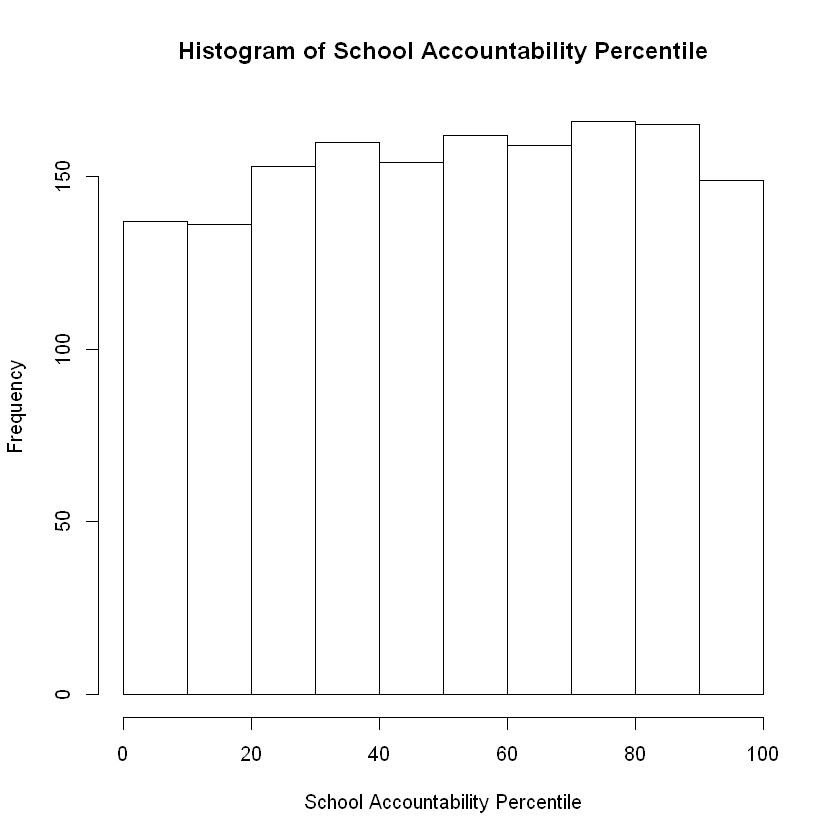

In [46]:
hist(school.perf$SchoolAccountablityPercentile, 
                         breaks = c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100), 
                         xlab = "School Accountability Percentile", 
                         main = "Histogram of School Accountability Percentile")

This data seems closely uniform, with a slight skew to the higher end.  With percentile data, this is something one would generally expect so I'll move on to other analysis.

## Correlations to School Performance

Next I will look at some basic correlations between our dependent variable with the others to identify any additional patterns.

In [47]:
correlation <- cor(na.omit(school.perf.num))
school.perf.correlation <- correlation[, c('SchoolAccountablityPercentile')]
print(school.perf.correlation)

                        TotalEnrollment                 FirstLanguageNotEnglish 
                            0.025457883                            -0.318991579 
             PctFirstLanguageNotEnglish                  EnglishLanguageLearner 
                           -0.440158043                            -0.454535755 
              PctEnglishLanguageLearner                StudentsWithDisabilities 
                           -0.495586930                            -0.130407556 
            PctStudentsWithDisabilities                               HighNeeds 
                           -0.282187069                            -0.467228909 
                           PctHighNeeds               EconomicallyDisadvantaged 
                           -0.771495304                            -0.581014773 
           PctEconomicallyDisadvantaged                        TotalNoOfClasses 
                           -0.805720618                             0.009464152 
                       Avera

Based on these correlations, a few things stand out:

* The higher the percentage of high needs children in the school, the lower the performance of the school
* The higher the percentage of economically disadvantaged children in the school, the lower the performance of the school
* The more the *district* as a whole is improving (as measured by the DistrictProgressAndPerformanceAll variable), the better the individual school is performing
* None of the individual school profile data (e.g., Average Salary, Class Size, etc.) seem to have much impact on the performance of the school

## Deeper Dive into School Performance

Below I will plot the performance of a school based on these three seemingly important variables: % of High Needs, % of Economically Disadvantaged, and District Progress and Performance.  I will also add one categorical value to the analysis, School Type.  School Type is a classification of a school as either a public school or a charter school.  I am not adding the other categorical variables contained in the data.  Each of them either contain far too many values to be useful or are simply proxies for other variables already used.

**Note:** *Charter Schools do not belong to a district, therefore the school performance equals the "district" performance and that factor has been removed from the plot below.*

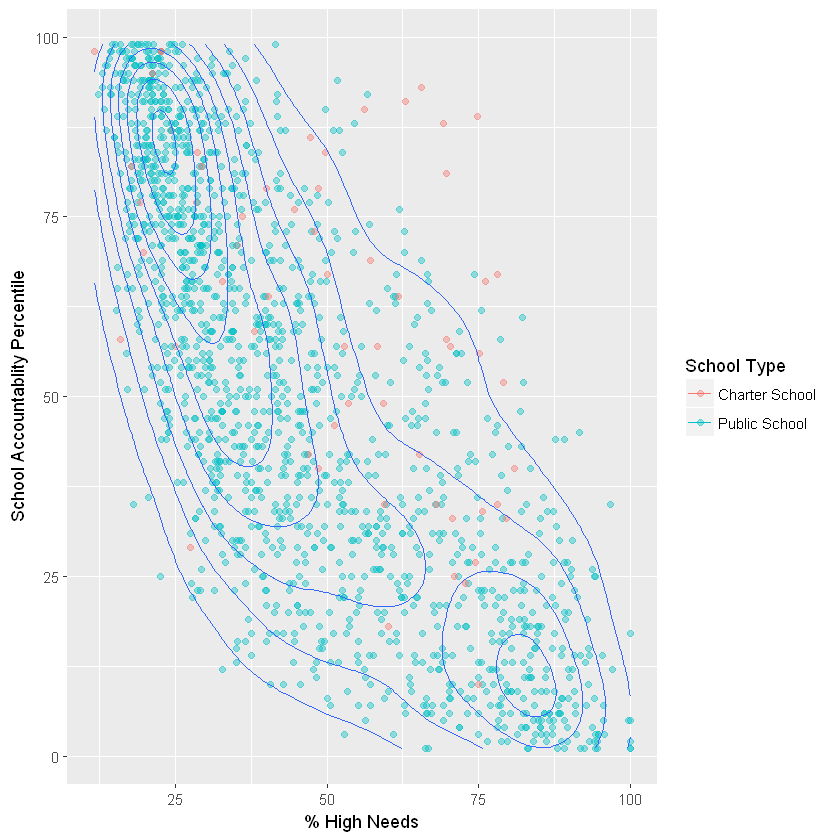

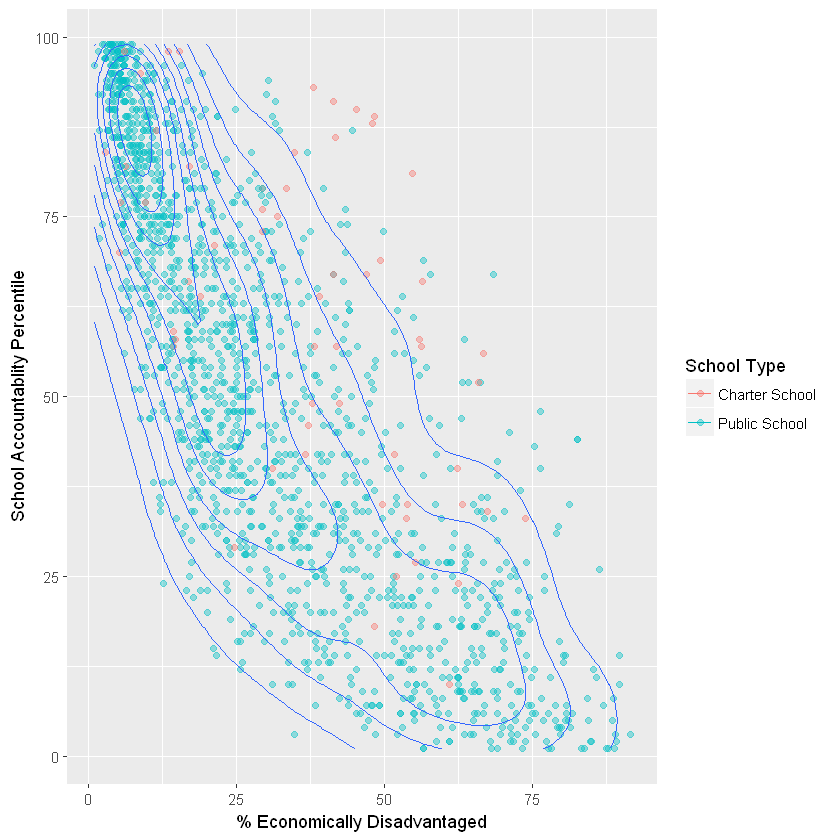

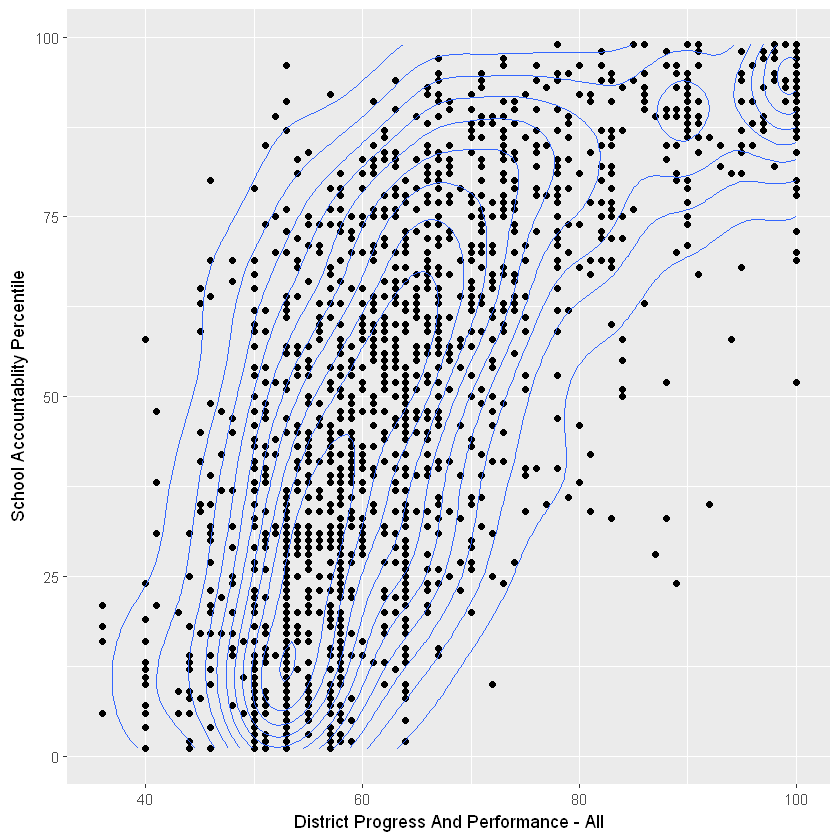

In [48]:
#Plot performance by size and school type
ggplot(school.perf, aes(PctHighNeeds, SchoolAccountablityPercentile)) + 
geom_point(aes(color=factor(SchoolType)), alpha=.4) + 
geom_density2d() +
labs(x = "% High Needs", y = "School Accountablity Percentile", color = "School Type")

ggplot(school.perf, aes(PctEconomicallyDisadvantaged, SchoolAccountablityPercentile)) + 
geom_point(aes(color=factor(SchoolType)), alpha=.4) + 
geom_density2d() +
labs(x = "% Economically Disadvantaged", y = "School Accountablity Percentile", color = "School Type")

#Remove school type as charter schools do not belong to districts
ggplot(school.perf, aes(DistrictProgressAndPerformanceAll, SchoolAccountablityPercentile)) + 
geom_point() + 
geom_density2d() +
labs(x = "District Progress And Performance - All", y = "School Accountablity Percentile")

The charts above show a few things fairly well:

* Schools that have a smaller percentage of high needs students perform better
* Schools that have a smaller percentage of economically disadvantaged students perform better  
* Schools that are in districts that are progressing well perform better

All this does is simply confirm what we saw in the correlation matrix. Unfortunately, these are all a bit of a sad statistic about our schools.

However, there are a couple of things that the plots show which did not appear in the simple correlation matrix:

* The performance of schools as compared to district progress is seemingly only slightly positive at the bottom left of the chart (lesser progressing districts).  It's not until you get towards the top 1/3 of the progressing districts do you see a truly positive effect on the school's performance.
* Perhaps most notable is the relative performance of charter schools when measured against the percentage of high needs and economically disadvantaged students.  You can see there is a higher proportion of red (Charter Schools) outside of the main densities and to the upper right quadrant of the plots.  This suggests these schools are performing much better than public schools with an equal percentage of these types of students.

Just to focus on this potential difference between charter and public schools, I will run a violin plot between these two against their performance.  This will not specifically take into effect the percentage of kids that are high needs or economically disadvantaged, but just their performance as a whole.

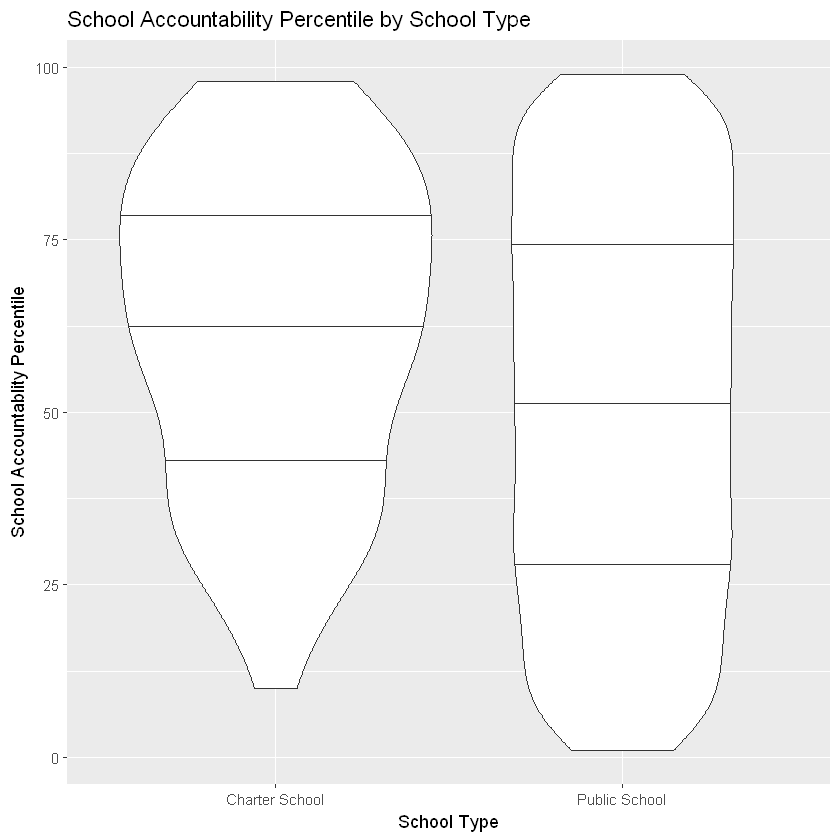

In [49]:
#Plot performance by school type
ggplot(school.perf, aes(x = factor(SchoolType), y = SchoolAccountablityPercentile)) + 
geom_violin(na.rm = TRUE, trim = TRUE, draw_quantiles = c(0.25, 0.5, 0.75)) +
labs(x = "School Type", y = "School Accountablity Percentile", title = "School Accountability Percentile by School Type")

This plot above shows that Charter Schools do tend to be better performing overall.  So now we've identified another factor that seems to contribute to school performance.

## Class Size

Class size is an oft talked about factor in school performance nationwide.  A lot of money is spent every year by many states to reduce class sizes with the hope of improved performance.  I decided to look at this factor specifically to see if it does seem to impact performance in the case of Massachusetts schools in 2016.

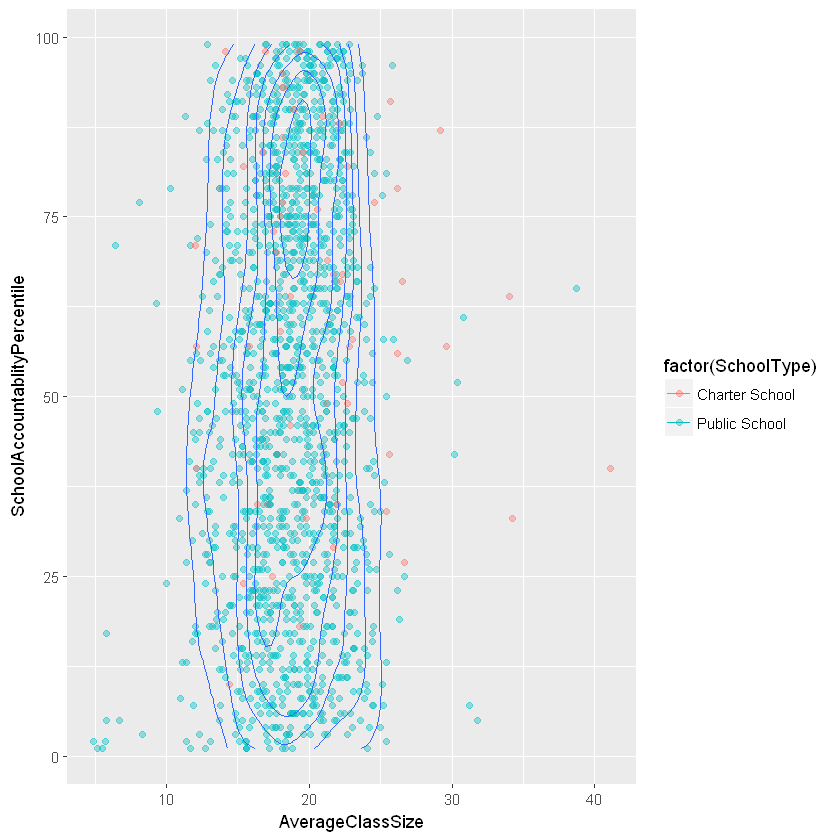

In [50]:
ggplot(school.perf, aes(AverageClassSize, SchoolAccountablityPercentile)) + 
geom_point(aes(color=factor(SchoolType)), alpha=.4, na.rm = TRUE) +
geom_density_2d(na.rm = TRUE)

Surprisingly, class size seems to have little effect on performance.  In fact, there's a decent cluster of schools with extremely small class sizes which do not perform well at all.  There are also a fair number of schools with very large class sizes that seem to perform just as well as many with the same or smaller class sizes.  Interestingly again, a larger proportion of these higher performing schools with large class sizes are charter schools.

## Testing for Significance

All this data exploration has helped us refine some of the more important variables.  I will now test these factors for significance.  I will use a combination of ANOVA tests and Tukey's HSD as well as boostrapping.

### ANOVA and Tukey's HSD

I've split up the below into three categories, small, medium, and large.  Using the "cut" function, I've identified the breakpoints as below.  I will run the ANOVA and Tukey's HSD on this data to test for significance.  This also means there is significant power to the test since there are over 1400 samples in total and each group would have an equal number of samples.

* % of High Needs Students - Small (&lt;41.1%), Medium (>41.1% and &lt;70.6%), and Large (>70.6%)
* % of Economically Disadvantaged Students - Small (&lt;31.3%), Medium (>31.3% and &lt;61.4%), and Large (>61.4%)
* District Performance - Small (&lt;60%), Medium (>57.3% and &lt;78.7%), and Large (>78.7%)

In [51]:
#Setup data frames
school.perf <- mutate(school.perf, 
            HighNeedsSize = ifelse(PctHighNeeds < 41.1, "Small", ifelse(PctHighNeeds < 70.6, "Medium", "Large")))
school.perf <- mutate(school.perf, 
            EDSize = ifelse(PctEconomicallyDisadvantaged < 31.3, "Small", 
                                   ifelse(PctEconomicallyDisadvantaged < 61.4, "Medium", "Large")))
school.perf <- mutate(school.perf, 
            DPPSize = ifelse(DistrictProgressAndPerformanceAll < 57.3, "Small", 
                                   ifelse(DistrictProgressAndPerformanceAll < 78.7, "Medium", "Large")))

school.perf$HighNeedsSize <- factor(school.perf$HighNeedsSize)
school.perf$EDSize <- factor(school.perf$EDSize)
school.perf$DPPSize <- factor(school.perf$DPPSize)

### High Needs

In [52]:
#Run ANOVA and Tukey HSD on High Needs
HighNeedsSize <- aov(SchoolAccountablityPercentile ~ HighNeedsSize, data = school.perf)
summary(HighNeedsSize)
print(HighNeedsSize)
taHighNeedsSize = TukeyHSD(HighNeedsSize)
taHighNeedsSize

                Df Sum Sq Mean Sq F value Pr(>F)    
HighNeedsSize    2 598606  299303     728 <2e-16 ***
Residuals     1538 632293     411                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Call:
   aov(formula = SchoolAccountablityPercentile ~ HighNeedsSize, 
    data = school.perf)

Terms:
                HighNeedsSize Residuals
Sum of Squares       598605.9  632293.5
Deg. of Freedom             2      1538

Residual standard error: 20.27595
Estimated effects may be unbalanced


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SchoolAccountablityPercentile ~ HighNeedsSize, data = school.perf)

$HighNeedsSize
                 diff      lwr      upr p adj
Medium-Large 21.44456 17.83558 25.05354     0
Small-Large  49.98799 46.69213 53.28385     0
Small-Medium 28.54343 25.75354 31.33332     0


Based on the p-value being far below .05 and the fact that none of the pairs crosses 0, we can say that the % of High Needs students by this categorization is significant to School Performance.  The larger the percentage of high needs students the worse the performance.

### Economically Disadvantaged

In [53]:
#Run ANOVA and Tukey HSD on Economically Disadvantaged
EDSize <- aov(SchoolAccountablityPercentile ~ EDSize, data = school.perf)
summary(EDSize)
print(EDSize)
taEDSize = TukeyHSD(EDSize)
taEDSize

              Df Sum Sq Mean Sq F value Pr(>F)    
EDSize         2 613347  306674   763.8 <2e-16 ***
Residuals   1538 617552     402                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Call:
   aov(formula = SchoolAccountablityPercentile ~ EDSize, data = school.perf)

Terms:
                  EDSize Residuals
Sum of Squares  613347.4  617552.0
Deg. of Freedom        2      1538

Residual standard error: 20.03819
Estimated effects may be unbalanced


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SchoolAccountablityPercentile ~ EDSize, data = school.perf)

$EDSize
                 diff      lwr      upr p adj
Medium-Large 17.35445 13.36357 21.34533     0
Small-Large  50.85369 47.22658 54.48079     0
Small-Medium 33.49924 30.73734 36.26114     0


Based on the p-value being far below .05 and the fact that none of the pairs crosses 0, we can say that the % of Economically Disadvantaged students by this categorization is significant to School Performance. The larger the percentage of Economically Disadvantaged students the worse the performance.

### District Progress and Performance

In [54]:
#Run ANOVA and Tukey HSD on District Progress
DPPSize <- aov(SchoolAccountablityPercentile ~ DPPSize, data = school.perf)
summary(DPPSize)
print(DPPSize)
taDPPSize = TukeyHSD(DPPSize)
taDPPSize

              Df Sum Sq Mean Sq F value Pr(>F)    
DPPSize        2 550993  275496   623.2 <2e-16 ***
Residuals   1538 679906     442                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Call:
   aov(formula = SchoolAccountablityPercentile ~ DPPSize, data = school.perf)

Terms:
                 DPPSize Residuals
Sum of Squares  550993.0  679906.4
Deg. of Freedom        2      1538

Residual standard error: 21.0255
Estimated effects may be unbalanced


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SchoolAccountablityPercentile ~ DPPSize, data = school.perf)

$DPPSize
                  diff       lwr       upr p adj
Medium-Large -29.63045 -33.19429 -26.06661     0
Small-Large  -55.44296 -59.20420 -51.68171     0
Small-Medium -25.81251 -28.61255 -23.01247     0


Based on the p-value being far below .05 and the fact that none of the pairs crosses 0, we can say that the District Progress And Performance - All Students by this categorization is significant to School Performance. The better the progress of the school's district, the better the performance.

### Difference of Means Bootstrapping

* School Type - Charter Schools vs Public Schools
* School Type stratified by High Needs % categories - High, Medium, and Small
* School Type stratified by Economically Disadvantaged % categories - High, Medium, and Small

The categorical variable of school type seems to be significant based on the exploration above.  Because there aren't enough values for charter schools, 60 compared to over 1400 for public schools, I cannot use a t-test or ANOVA for significance.  Those tests do not have enough power.  I will instead use a two-sided bootstrap test for difference of means to test for significance.

In [55]:
#Setup function
plot.diff.means <- function(dataFrame1, dataframe2, title){
    #run the difference in means and remove NAs
    twoBootMean <- two.boot(dataFrame1, dataframe2, 
                                    mean, R = 10000)
    cleanTwoBootMean <- na.omit(twoBootMean$t)
    
    #Find the confidence intervals and print numeric values
    lowerConfidenceInterval <- round(quantile(cleanTwoBootMean, probs = .025), 5)
    upperConfidenceInterval <- round(quantile(cleanTwoBootMean, probs = (1 - .025)), 5)
    confInt = data.frame(LowerBound = c(lowerConfidenceInterval), UpperBound = c(upperConfidenceInterval))
    row.names(confInt) = c(paste("95% Confidence Interval"))
    #print(confInt)
    
    #Fin min and max values for plotting
    maxIncomeDiff <- max(cleanTwoBootMean)
    minIncomeDiff <- min(cleanTwoBootMean)
    breaks <- seq(maxIncomeDiff, minIncomeDiff, length.out = 11)
    
    #plot histogram with lines for the mean, the 95% CIs, and zero
    par(mfrow=c(1,2), mar = c(8,2,8,2))
    hist(cleanTwoBootMean, breaks = breaks, 
         main = paste("Difference in Means \n", title), xlab = "Difference of Means")
    abline(v = mean(cleanTwoBootMean), lwd = 4, col = 'red')
    abline(v = 0, lwd = 4, col = 'blue')
    abline(v = quantile(cleanTwoBootMean, probs = .025), lty = 3, col = 'red', lwd = 3)
    abline(v = quantile(cleanTwoBootMean, probs = (1 - .025)), lty = 3, col = 'red', lwd = 3)
    
    qqnorm(cleanTwoBootMean)
}

### School Type

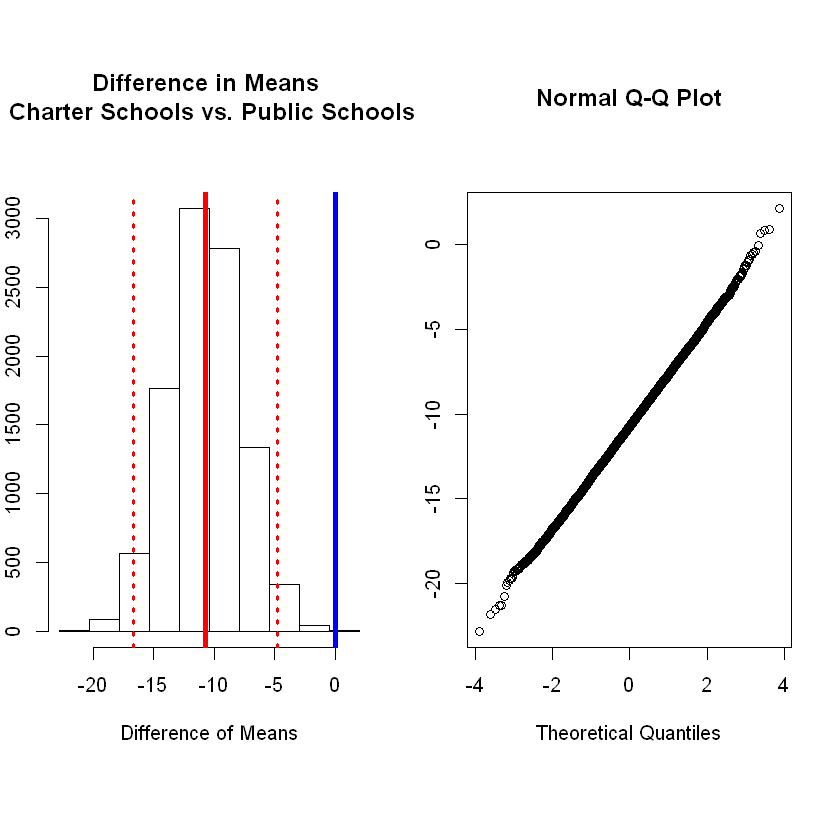

In [56]:
school.perf.public <- filter(school.perf, SchoolType == 'Public School')
school.perf.charter <- filter(school.perf, SchoolType == 'Charter School')

plot.diff.means(school.perf.public$SchoolAccountablityPercentile, school.perf.charter$SchoolAccountablityPercentile,
                   title = "Charter Schools vs. Public Schools")

The plots above show very distinctly that Public vs Charter is significant as it relates to school performance.  The 95% confidence interval clearly does not cross zero and therefore we can reject the null hypothesis.  The Q-Q plot also shows as a straight line, indicating a normal distribution as we would expect.

### High Needs Categories

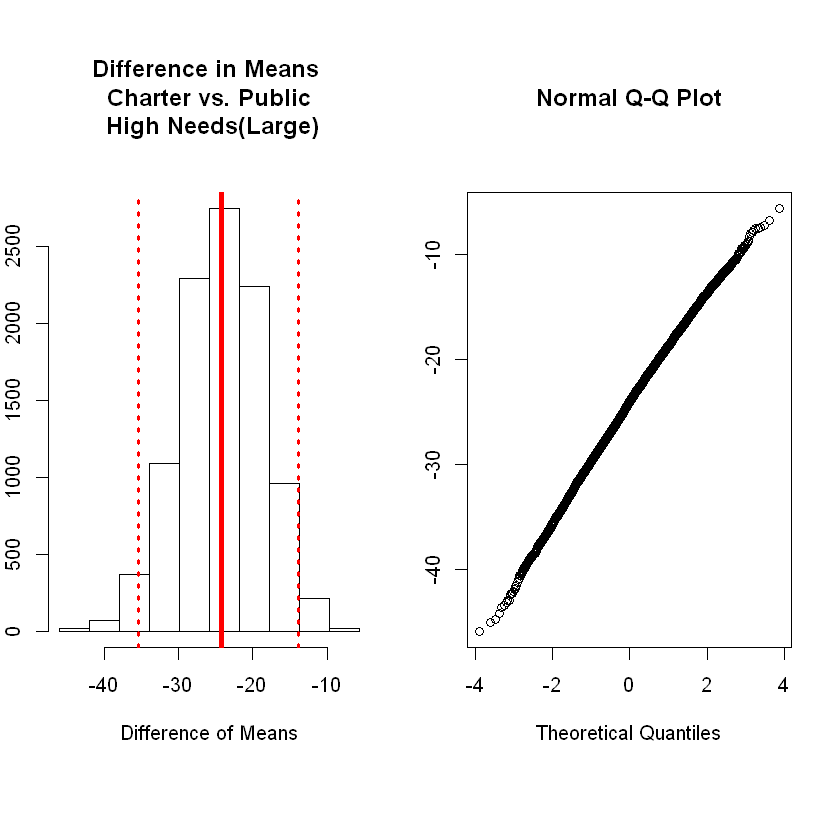

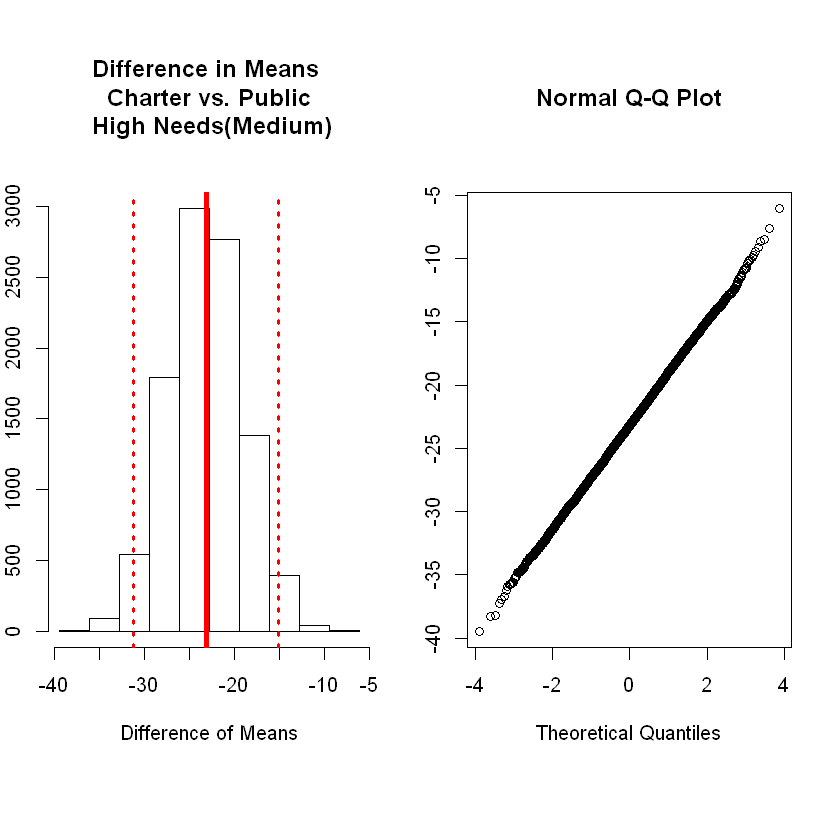

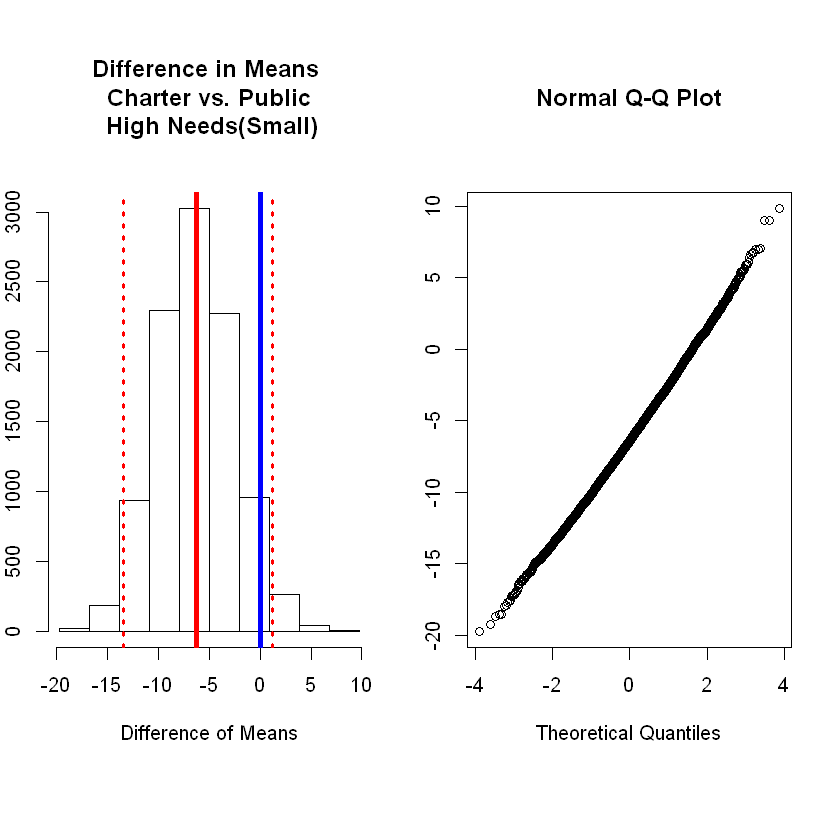

In [57]:
school.perf.public.HN.High <- filter(school.perf.public, HighNeedsSize == 'Large')
school.perf.charter.HN.High <- filter(school.perf.charter, HighNeedsSize == 'Large')
school.perf.public.HN.Medium <- filter(school.perf.public, HighNeedsSize == 'Medium')
school.perf.charter.HN.Medium <- filter(school.perf.charter, HighNeedsSize == 'Medium')
school.perf.public.HN.Small <- filter(school.perf.public, HighNeedsSize == 'Small')
school.perf.charter.HN.Small <- filter(school.perf.charter, HighNeedsSize == 'Small')
HNLarge <- plot.diff.means(school.perf.public.HN.High$SchoolAccountablityPercentile, 
                school.perf.charter.HN.High$SchoolAccountablityPercentile,
                   title = "Charter vs. Public \n High Needs(Large)")
HNMedium <- plot.diff.means(school.perf.public.HN.Medium$SchoolAccountablityPercentile, 
                school.perf.charter.HN.Medium$SchoolAccountablityPercentile,
                   title = "Charter vs. Public \n High Needs(Medium)")
HNSmall <- plot.diff.means(school.perf.public.HN.Small$SchoolAccountablityPercentile, 
                school.perf.charter.HN.Small$SchoolAccountablityPercentile,
                   title = "Charter vs. Public \n High Needs(Small)")

When stratifying by the various high needs categoricals and public school vs charter schools, we can see that two of the three are significant as the 95% confidence intervals do not cross zero.  Only when the High Needs percentage of students is small is charter vs public school not significant.  Charter schools appear to perform better than public schools at similar % of students that are high needs.

### Economically Disadvantaged Categories

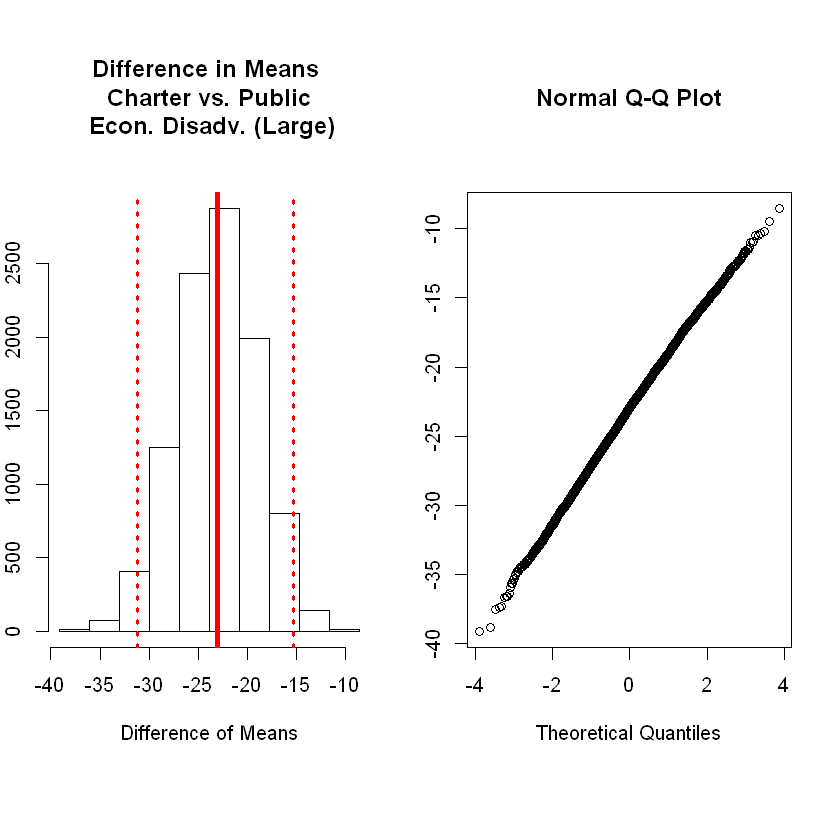

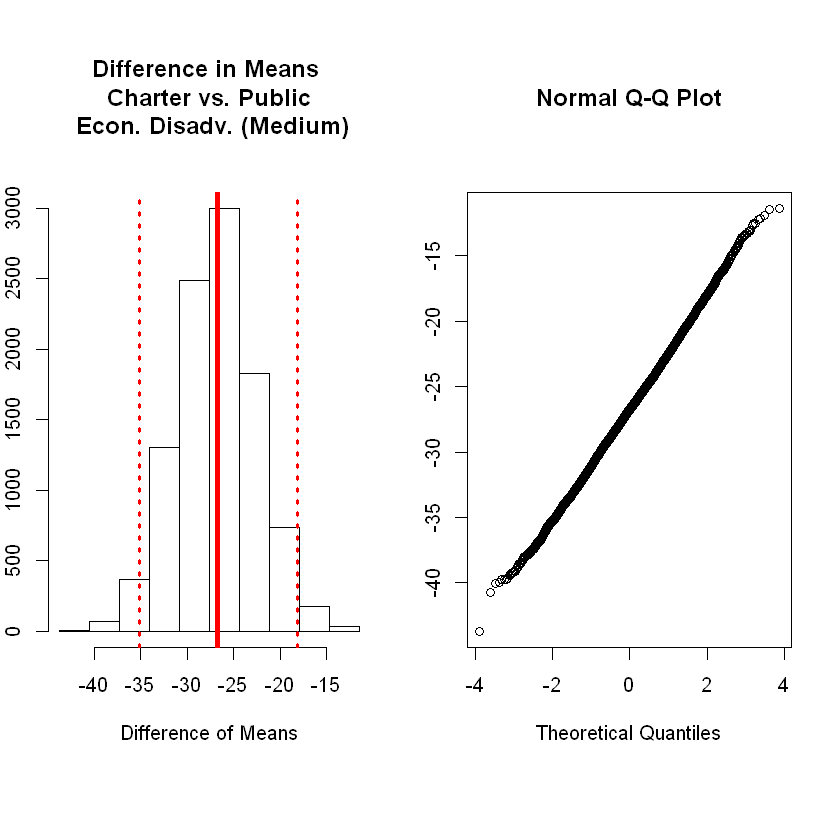

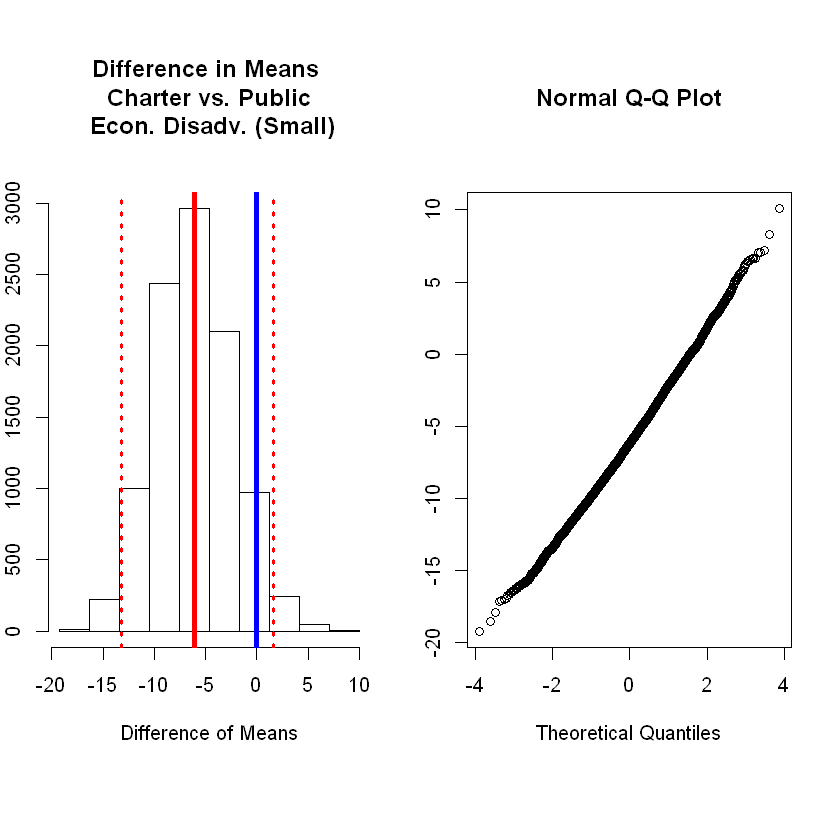

In [58]:
school.perf.public.ED.High <- filter(school.perf.public, EDSize == 'Large')
school.perf.charter.ED.High <- filter(school.perf.charter, EDSize == 'Large')
school.perf.public.ED.Medium <- filter(school.perf.public, EDSize == 'Medium')
school.perf.charter.ED.Medium <- filter(school.perf.charter, EDSize == 'Medium')
school.perf.public.ED.Small <- filter(school.perf.public, EDSize == 'Small')
school.perf.charter.ED.Small <- filter(school.perf.charter, EDSize == 'Small')
EDLarge <- plot.diff.means(school.perf.public.ED.High$SchoolAccountablityPercentile, 
                school.perf.charter.ED.High$SchoolAccountablityPercentile,
                   title = "Charter vs. Public \n Econ. Disadv. (Large)")
EDMedium <- plot.diff.means(school.perf.public.ED.Medium$SchoolAccountablityPercentile, 
                school.perf.charter.ED.Medium$SchoolAccountablityPercentile,
                   title = "Charter vs. Public \n Econ. Disadv. (Medium)")
EDSmall <- plot.diff.means(school.perf.public.ED.Small$SchoolAccountablityPercentile, 
                school.perf.charter.ED.Small$SchoolAccountablityPercentile,
                   title = "Charter vs. Public \n Econ. Disadv. (Small)")

Similar to the high needs results, when stratifying by the various economically disadvantaged categoricals and public school vs charter schools, we can see that two of the three are significant as the 95% confidence intervals do not cross zero.  Only when the economically disadvantaged percentage of students is small is charter vs public school not significant.  Charter schools appear to perform better than public schools at similar % of students that are economically disadvantaged.

## Elastic Net Regression

Finally, I will run a elastic net regression analysis to model the data.

In [59]:
#Setup function
plot.svd.reg <- function(df, k = 4){
  
  p1 <- ggplot(df) + 
            geom_point(aes(score, resids), size = 2) + 
            stat_smooth(aes(score, resids)) +
            ggtitle('Residuals vs. fitted values')
 
  p2 <- ggplot(df, aes(resids)) +
           geom_histogram(aes(y = ..density..)) +
           geom_density(color = 'red', fill = 'red', alpha = 0.2) +
           ggtitle('Histogram of residuals')

  qqnorm(df$resids)
    
  grid.arrange(p1, p2, ncol = 2)
    
  df$std.resids = sqrt((df$resids - mean(df$resids))^2)  
    
  p3 = ggplot(df) + 
            geom_point(aes(score, std.resids), size = 2) + 
            stat_smooth(aes(score, std.resids)) +
            ggtitle('Standardized residuals vs. fitted values')
  print(p3) 
    
  n = nrow(df)
  Ybar = mean(df$SchoolAccountablityPercentile)
  SST <- sum((df$SchoolAccountablityPercentile - Ybar)^2)
  SSR <- sum(df$resids * df$resids)
  SSE = SST - SSR
  cat(paste('SSE =', as.character(SSE), '\n'))
  cat(paste('SSR =', as.character(SSR), '\n'))
  cat(paste('SST =', as.character(SSE + SSR), '\n'))
  cat(paste('RMSE =', as.character(SSE/(n - 2)), '\n'))

  adjR2  <- 1.0 - (SSR/SST) * ((n - 1)/(n - k - 1))
  cat(paste('Adjusted R^2 =', as.character(adjR2)), '\n')
}

### Model

`geom_smooth()` using method = 'gam'
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


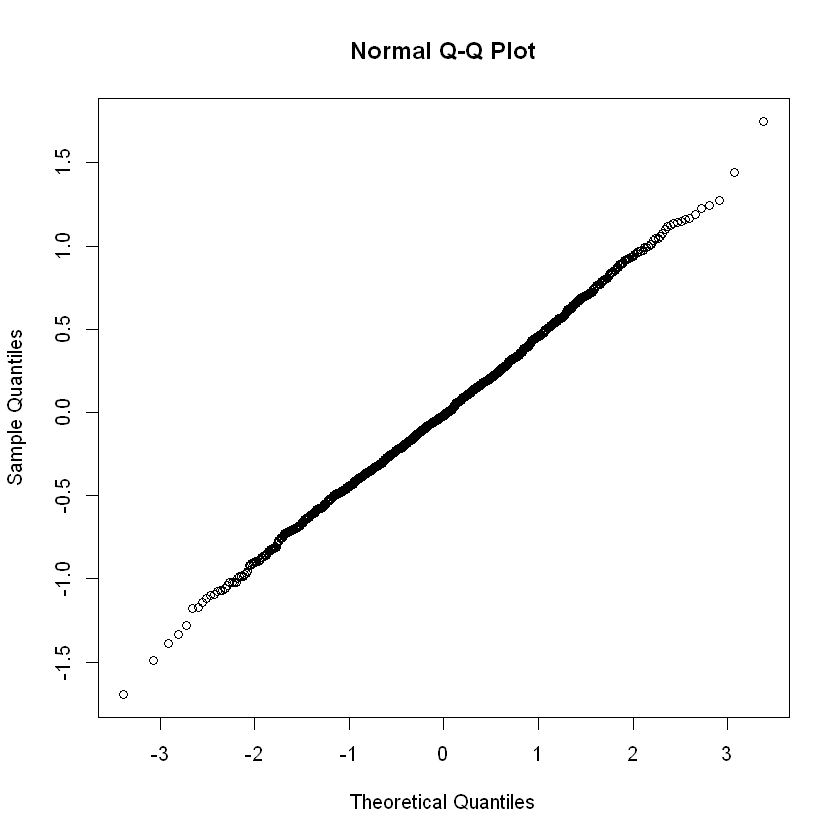

`geom_smooth()` using method = 'gam'


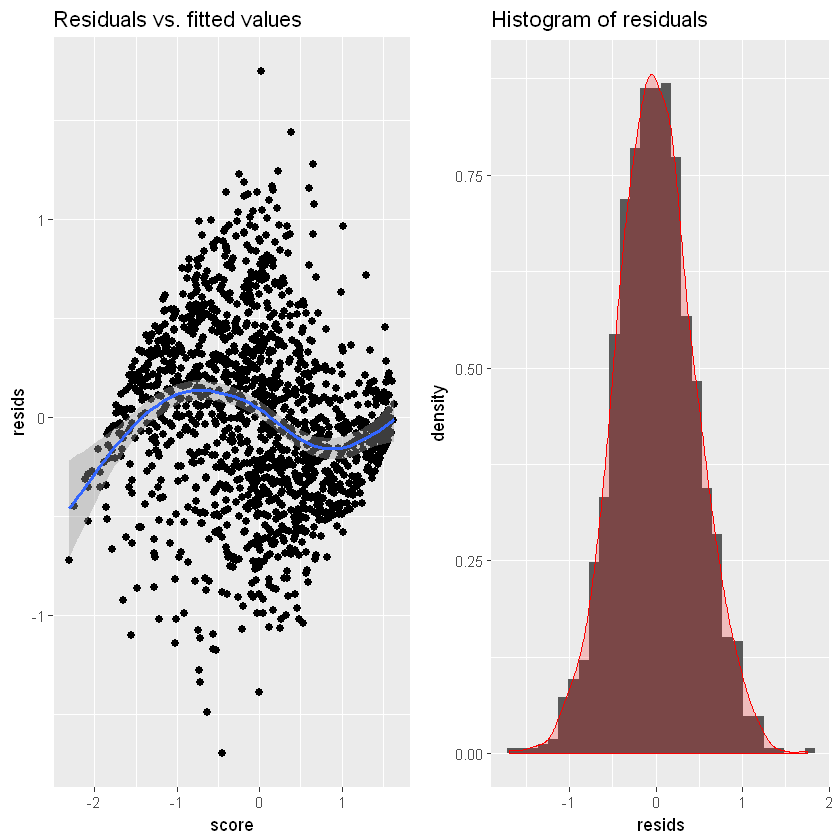

SSE = 1114.25485333835 
SSR = 288.854035750616 
SST = 1403.10888908896 
RMSE = 0.79989580282724 
Adjusted R^2 = 0.792645365126608 


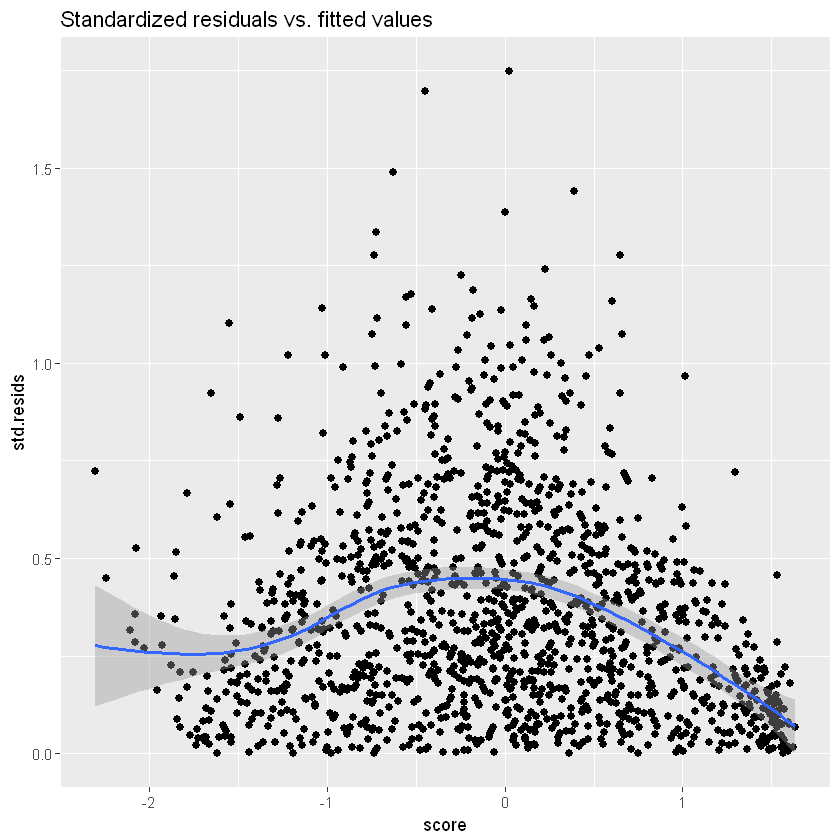

In [67]:
school.perf.clean <- na.omit(school.perf.scale)
school.perf.coeff <- na.omit(school.perf.scale)

sapMM <- model.matrix(SchoolAccountablityPercentile ~ PctEconomicallyDisadvantaged +  
                      DistrictProgressAndPerformanceAll + ProgressAndPerformanceAll + EconomicallyDisadvantaged + SchoolType
                      - 1, 
                      data = school.perf.clean)

b = as.matrix(school.perf.clean$SchoolAccountablityPercentile)
mod.ridge.lasso = glmnet(sapMM, b, family = 'gaussian', nlambda = 100,  alpha = 0.5)
school.perf.clean$score = predict(mod.ridge.lasso, newx = sapMM)[, 35]
school.perf.clean$resids = school.perf.clean$score - school.perf.clean$SchoolAccountablityPercentile

plot.svd.reg(school.perf.clean, 10)

This regression may not be the best model, but might be considered a decent one with an R^2 Adjusted of .79.  I've tried to balance the bias-variance relationship so as to not be too heavy in either direction and avoid over-fitting.  The q-q plot of the residuals is certainly in a normal distribution.  The histogram shows the same.  However the residuals are somewhat heteroscedastic which is not ideal. 

It can be seen that the three major factors identified earlier (PctHighNeeds, PctEconomicallyDisadvantaged, and DistrictProgressAndPerformanceAll) are part of the regression.  Those three alone in the model produced an R^2 Adjusted of about .72.  Adding the others below produced a slightly better model.

* ProgressAndPerformanceAll, EconomicallyDisadvantaged

The other school profile measures, like Total Expenditures and Average Salary, did not really contribute to the improvement of the model.  

And as for the specially called out feature of Average Class Size, that too did not seem to contribute much to the model either, which again is fairly surprising considering the emphasis on it in many states.

# Conclusions

Understanding school performance is not a simple subject.  If it were, all of our schools would be high performing.  In the above analysis I have been able to uncover some factors which appear to be significant to the performance of the schools in Massachusetts in the year 2016.

* The percentage of students a school has which are considered high needs impacts the performance of the school.  In general, the more high needs students a school has, the worse the school performance is.

* The percentage of students which are considered economically disadvantaged impacts the performance of the school as well.  The more economically disadvantaged students a school has as a percentage, the worse the school performance is.
    * The regression model also shows that the total number of students in this category within a school also contributes

* The better the school's district is progressing as a whole, the better the school performance is.

* In general, charter schools perform better than public schools

* Finally, and perhaps most interestingly, there is a significant improvement in performance of charter schools over public schools in the cases where there is a higher percentage of economically disadvantaged students and high needs students.  When the percentage is small, they both perform about the same.

This last fact about charter schools is not likely a panacea.  Simply turning all public schools into charter schools will not likely "fix" our schools.  But charter schools are certainly doing something differently than public schools to be able to teach students that fit these profiles more effectively.  Perhaps this data will spur some research into the methods of these successful charter schools in order to better serve this demographic of students.

In [132]:
rsq <- function(formula, data, indices) {
  d <- data[indices,] # allows boot to select sample 
  fit <- lm(formula, data=d)
  return(summary(fit)$r.square)
} 


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    SchoolType)


Bootstrap Statistics :
       original       bias    std. error
t1* 0.005443236 0.0004642191  0.00312973

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.001,  0.013 )  
Calculations and Intervals on Original Scale

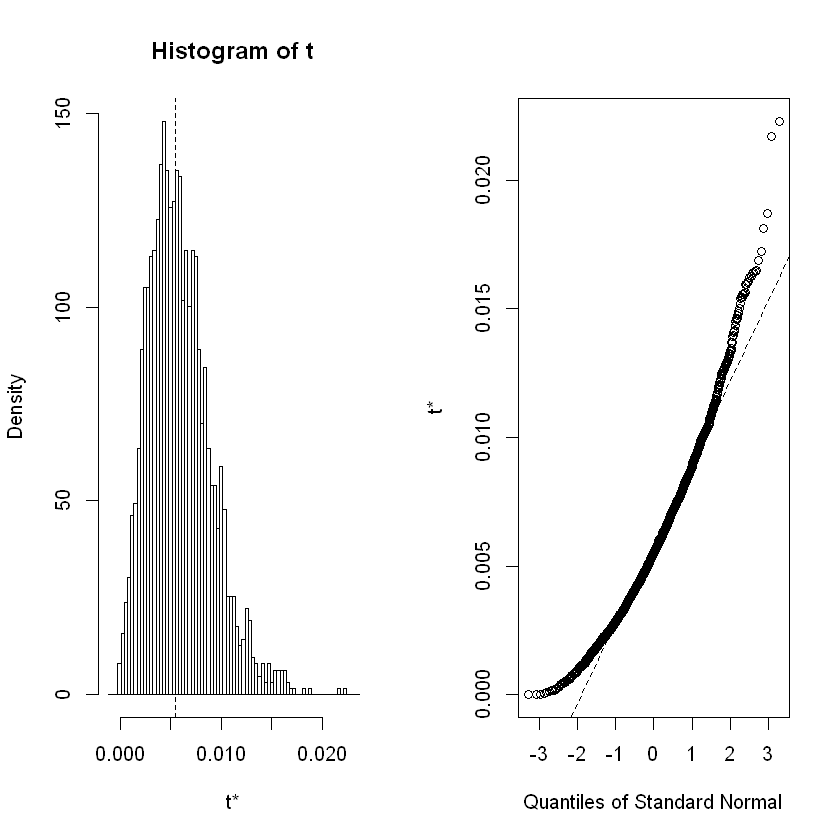

In [133]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~SchoolType)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    Grade)


Bootstrap Statistics :
      original     bias    std. error
t1* 0.07015513 0.01554188  0.01156494

Warning message in norm.inter(t, adj.alpha):
"extreme order statistics used as endpoints"

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0520,  0.0758 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable

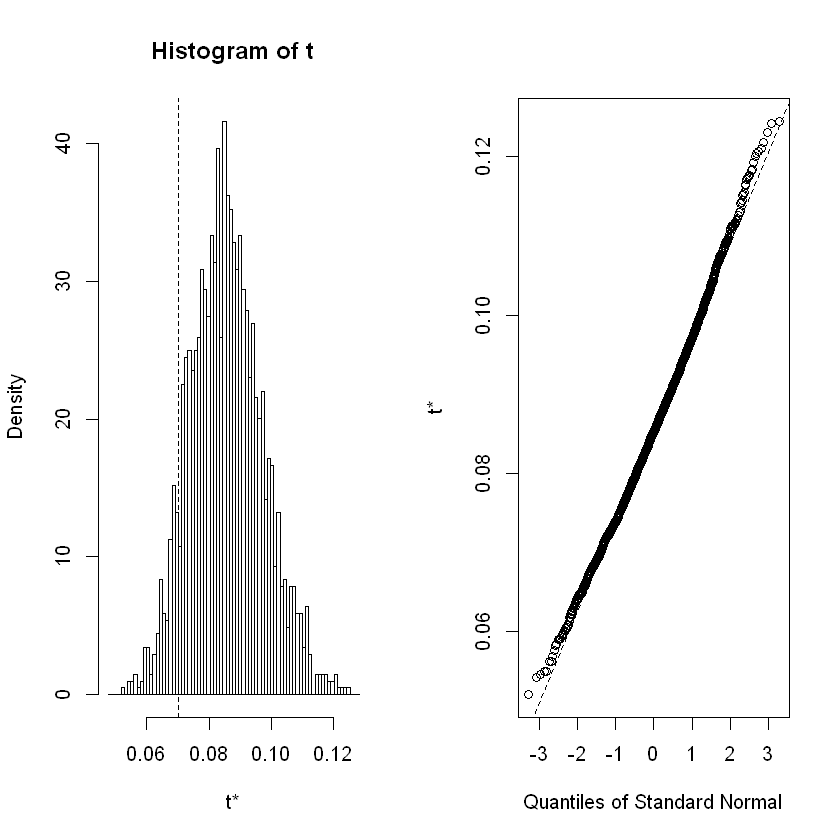

In [134]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~Grade)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    TotalEnrollment)


Bootstrap Statistics :
        original       bias    std. error
t1* 0.0004948278 0.0007517602 0.001660353

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0000,  0.0051 )  
Calculations and Intervals on Original Scale

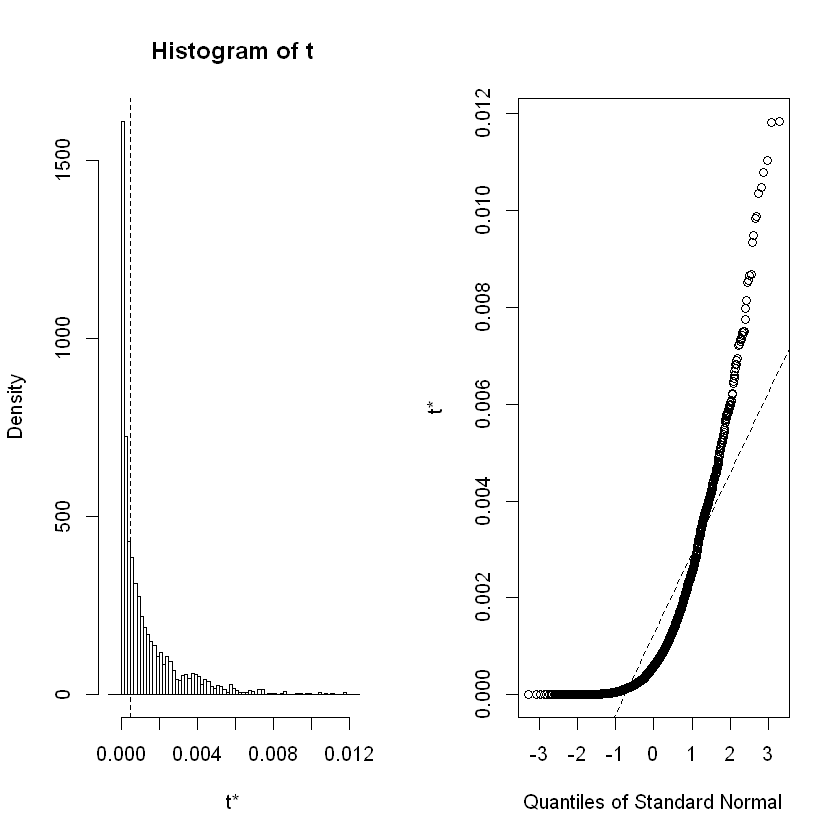

In [135]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~TotalEnrollment)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    FirstLanguageNotEnglish)


Bootstrap Statistics :
      original      bias    std. error
t1* 0.08705461 0.001074547   0.0134566

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0604,  0.1133 )  
Calculations and Intervals on Original Scale

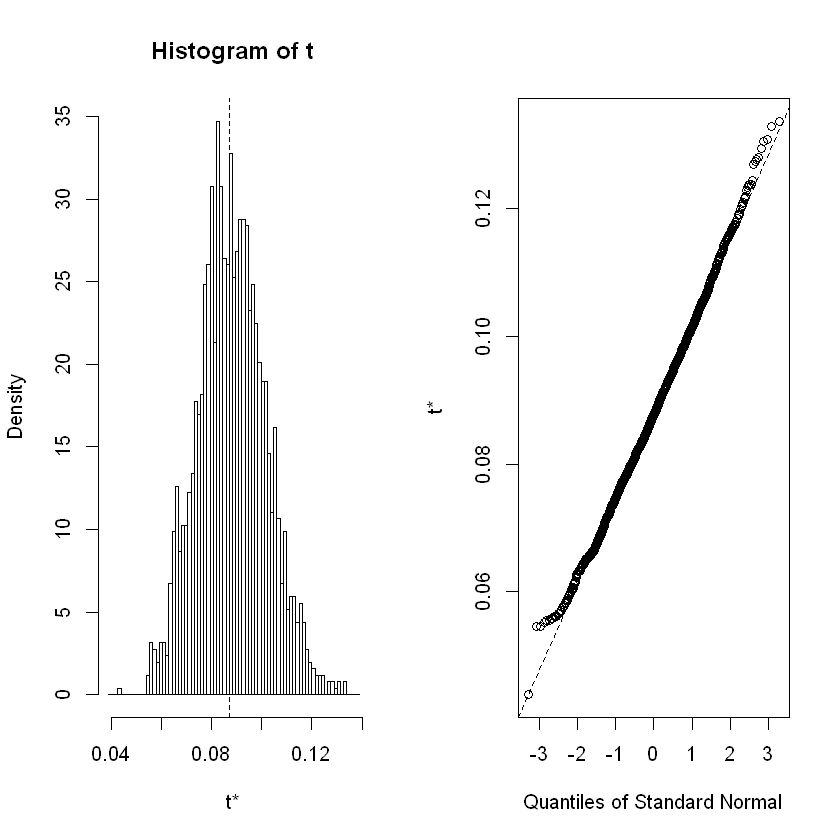

In [136]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~FirstLanguageNotEnglish)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    PctFirstLanguageNotEnglish)


Bootstrap Statistics :
    original       bias    std. error
t1*  0.17879 0.0008563291  0.01647148

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1453,  0.2099 )  
Calculations and Intervals on Original Scale

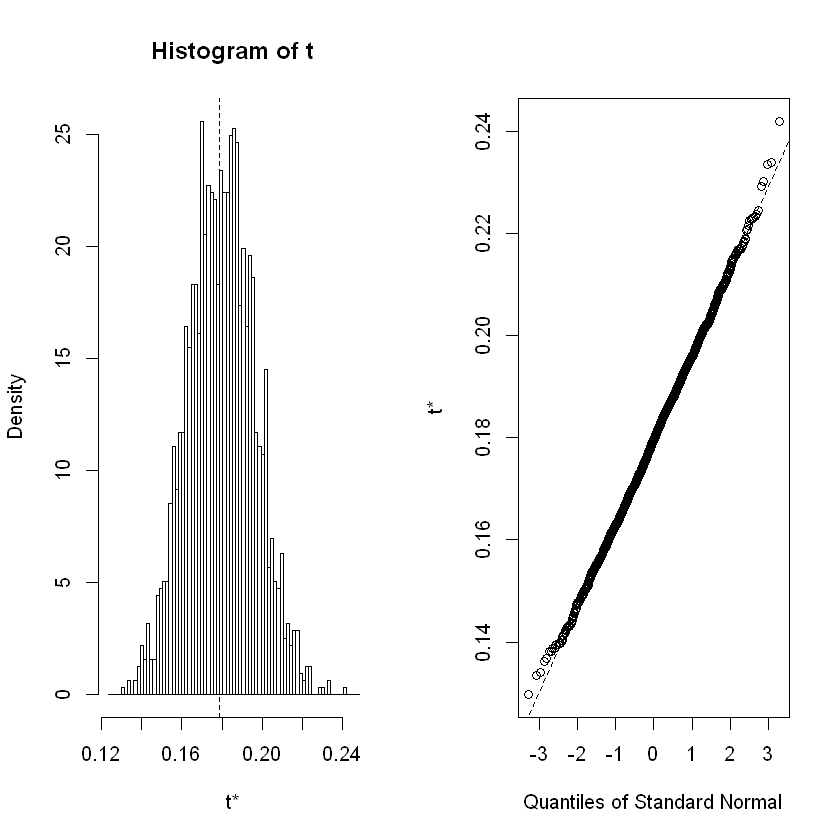

In [137]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~PctFirstLanguageNotEnglish)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    EnglishLanguageLearner)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.1840136 0.0003320669  0.01693701

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1513,  0.2177 )  
Calculations and Intervals on Original Scale

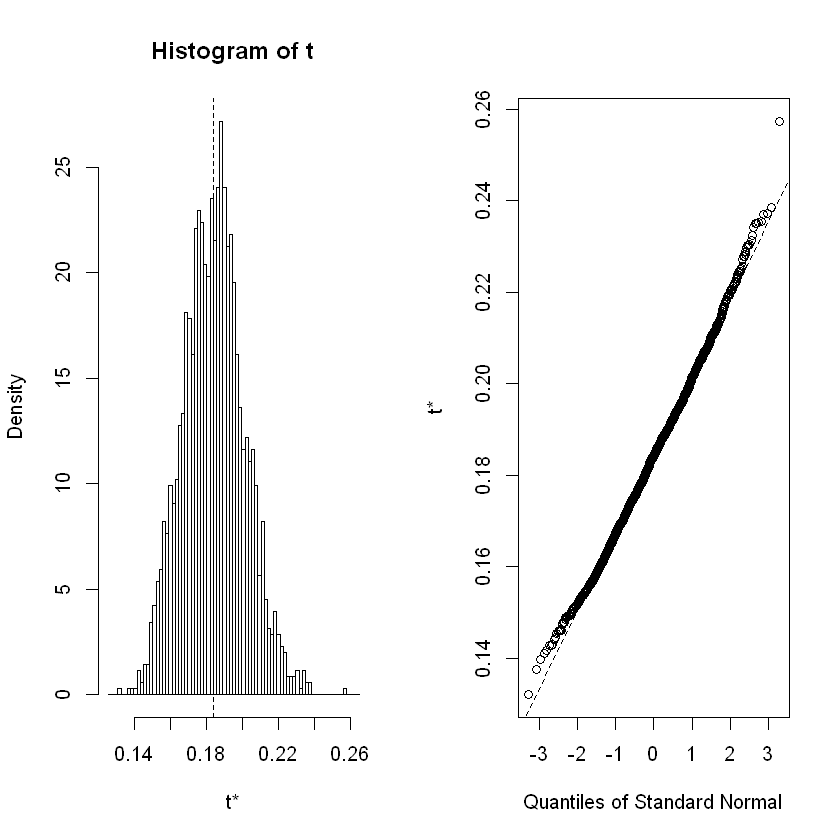

In [138]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~EnglishLanguageLearner)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    PctEnglishLanguageLearner)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.2316516 0.0007127553  0.01646198

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1992,  0.2631 )  
Calculations and Intervals on Original Scale

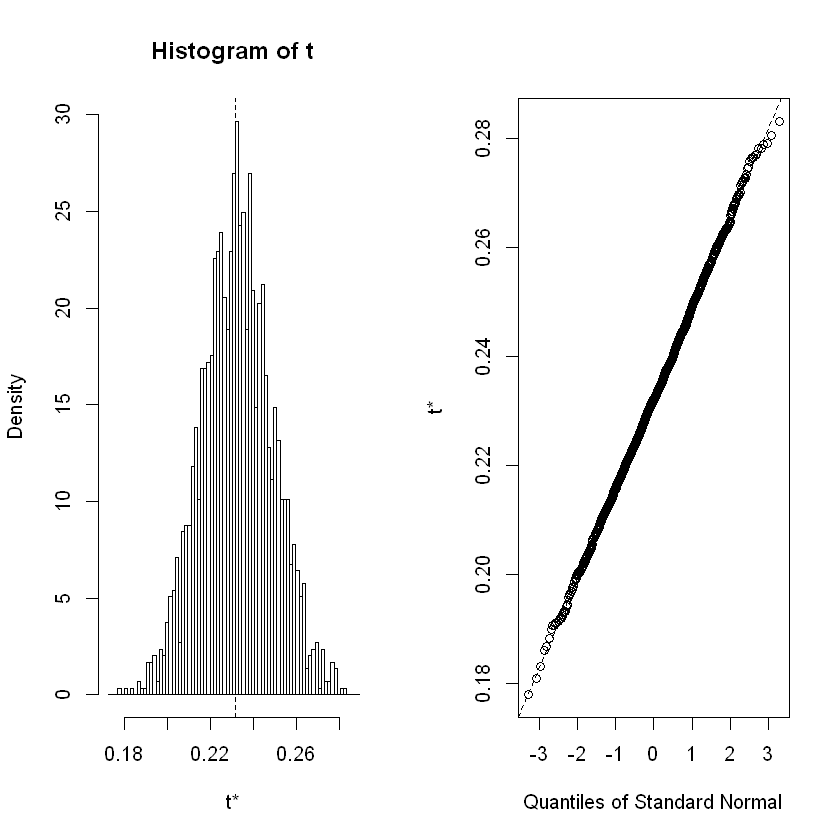

In [139]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~PctEnglishLanguageLearner)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    StudentsWithDisabilities)


Bootstrap Statistics :
      original       bias    std. error
t1* 0.01956042 0.0008215924 0.007258999

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0078,  0.0355 )  
Calculations and Intervals on Original Scale

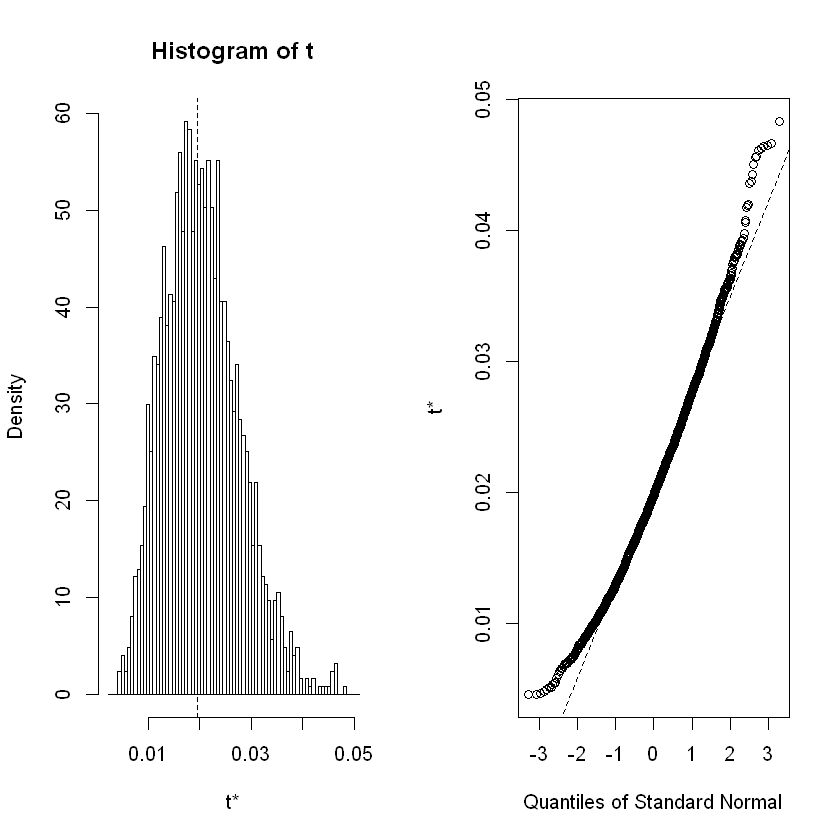

In [140]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~StudentsWithDisabilities)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    PctStudentsWithDisabilities)


Bootstrap Statistics :
      original       bias    std. error
t1* 0.08998309 0.0008340633  0.01028808

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.069,  0.110 )  
Calculations and Intervals on Original Scale

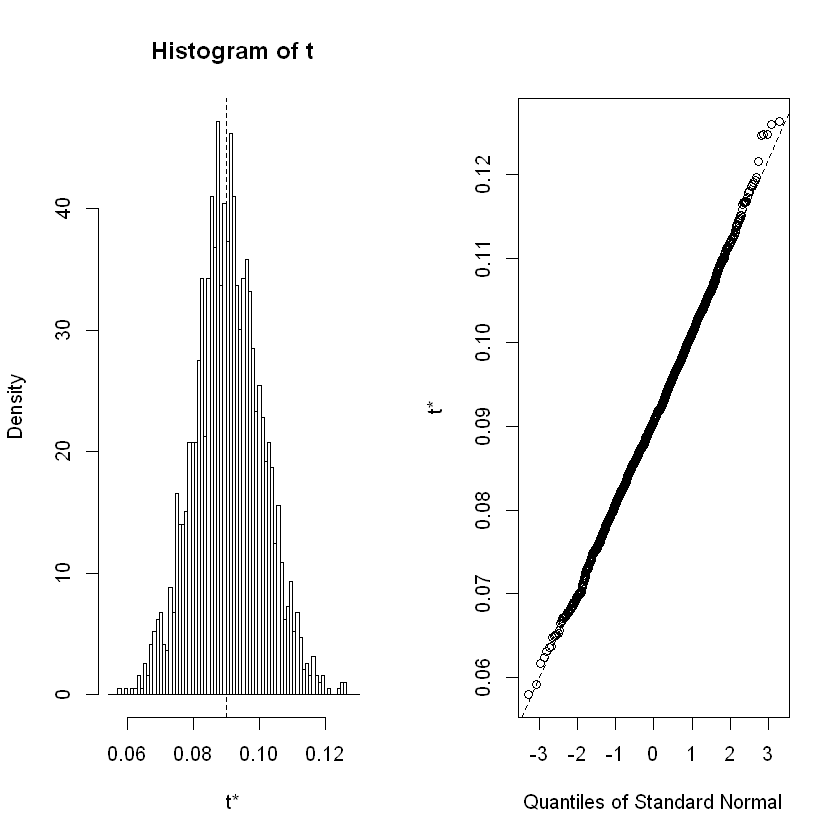

In [141]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~PctStudentsWithDisabilities)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    HighNeeds)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.1991484 0.001659492  0.01979911

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1555,  0.2338 )  
Calculations and Intervals on Original Scale

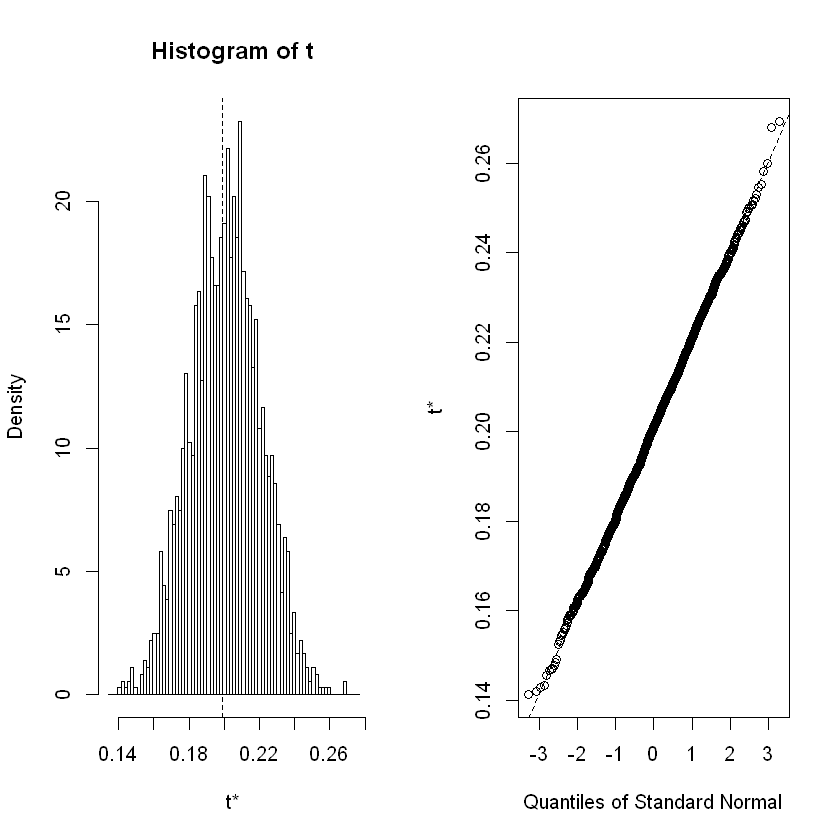

In [142]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~HighNeeds)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    PctHighNeeds)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.5784375 0.0009652947  0.01622144

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.5439,  0.6087 )  
Calculations and Intervals on Original Scale

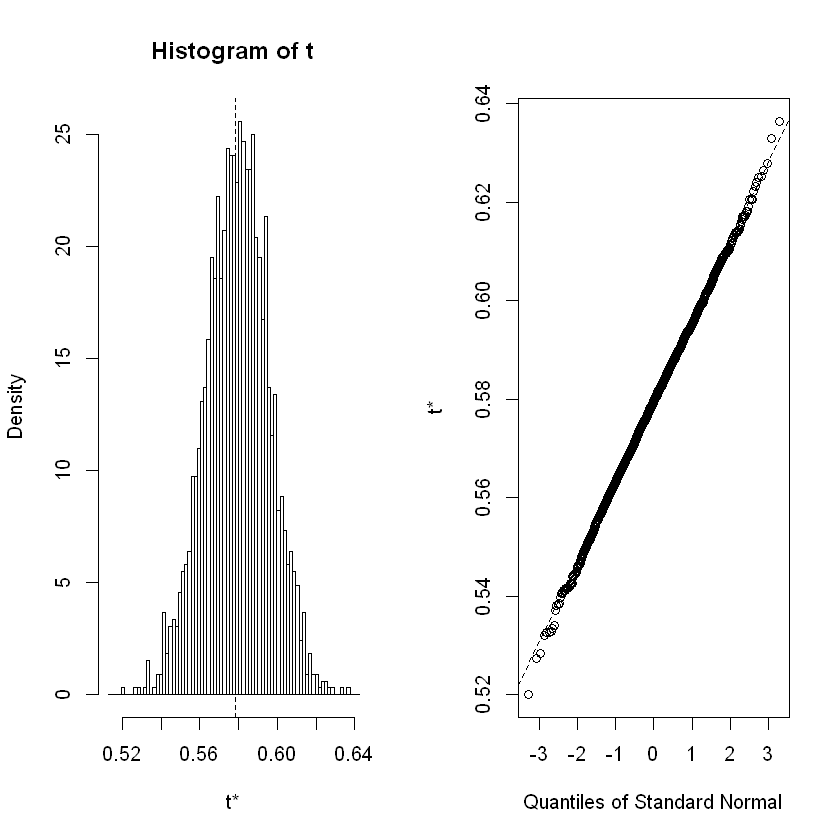

In [143]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~PctHighNeeds)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    EconomicallyDisadvantaged)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.3090586 0.002389887  0.02537936

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.2463,  0.3502 )  
Calculations and Intervals on Original Scale

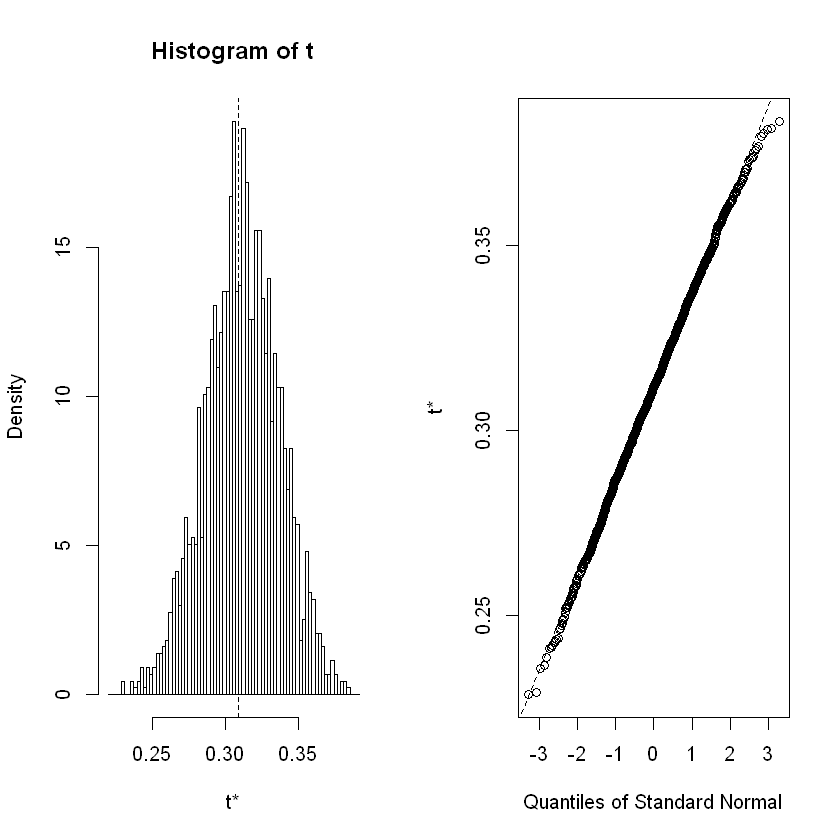

In [144]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~EconomicallyDisadvantaged)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    TotalNoOfClasses)


Bootstrap Statistics :
        original       bias    std. error
t1* 4.094407e-06 0.0007150545 0.001043925

Warning message in norm.inter(t, adj.alpha):
"extreme order statistics used as endpoints"

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0,  0 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable

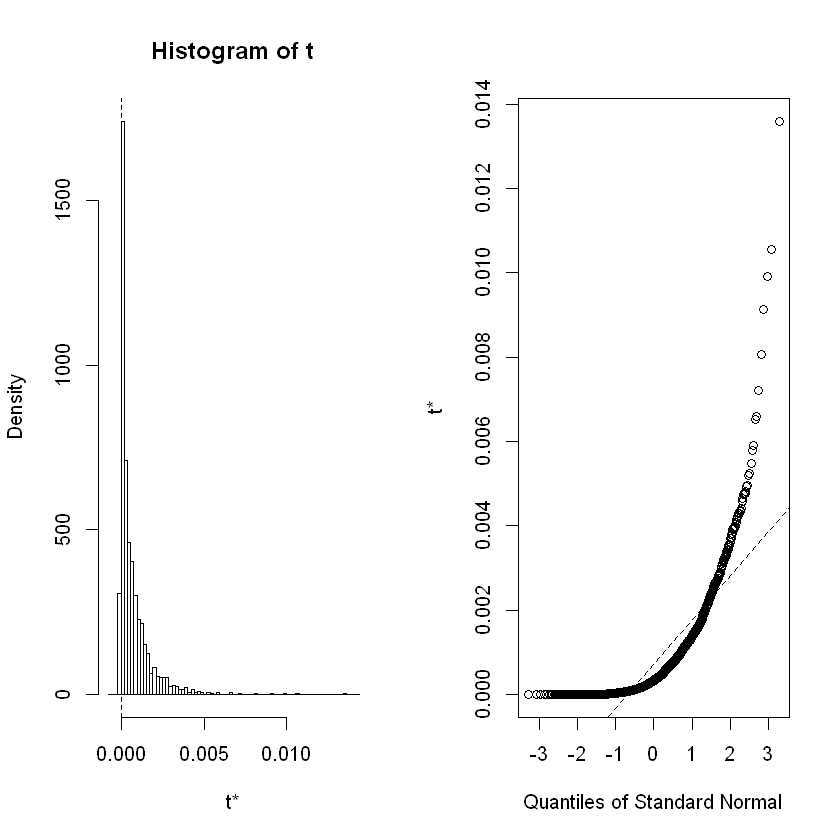

In [145]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~TotalNoOfClasses)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    AverageClassSize)


Bootstrap Statistics :
       original       bias    std. error
t1* 0.006597879 0.0006685163 0.004241266

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0013,  0.0177 )  
Calculations and Intervals on Original Scale

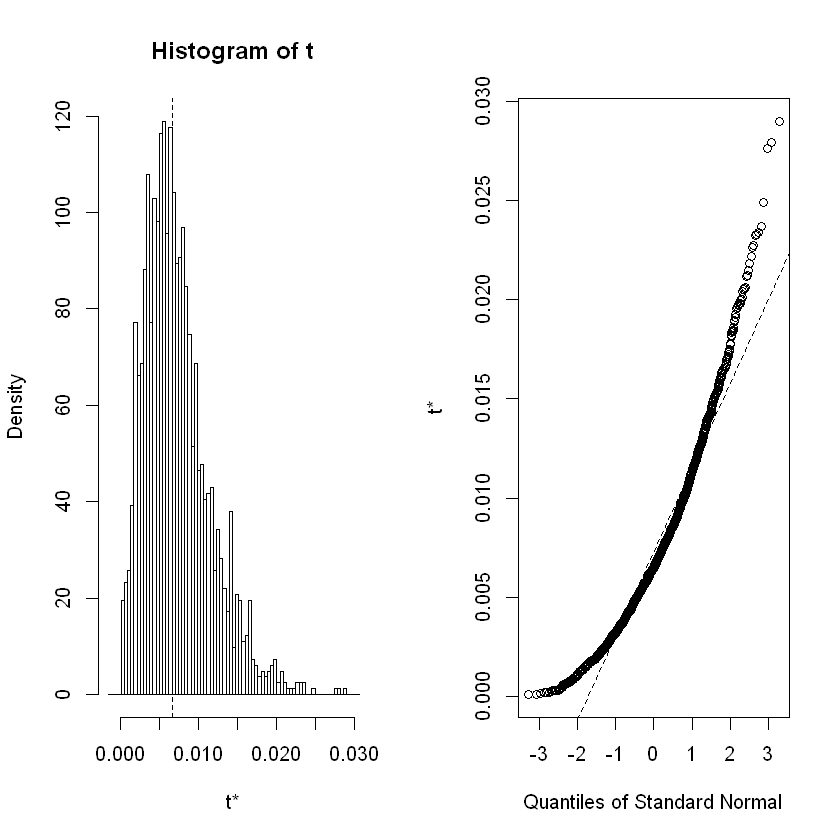

In [146]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~AverageClassSize)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    NumberOfStudents)


Bootstrap Statistics :
        original       bias    std. error
t1* 0.0001194262 0.0007300012 0.001234731

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0000,  0.0014 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable

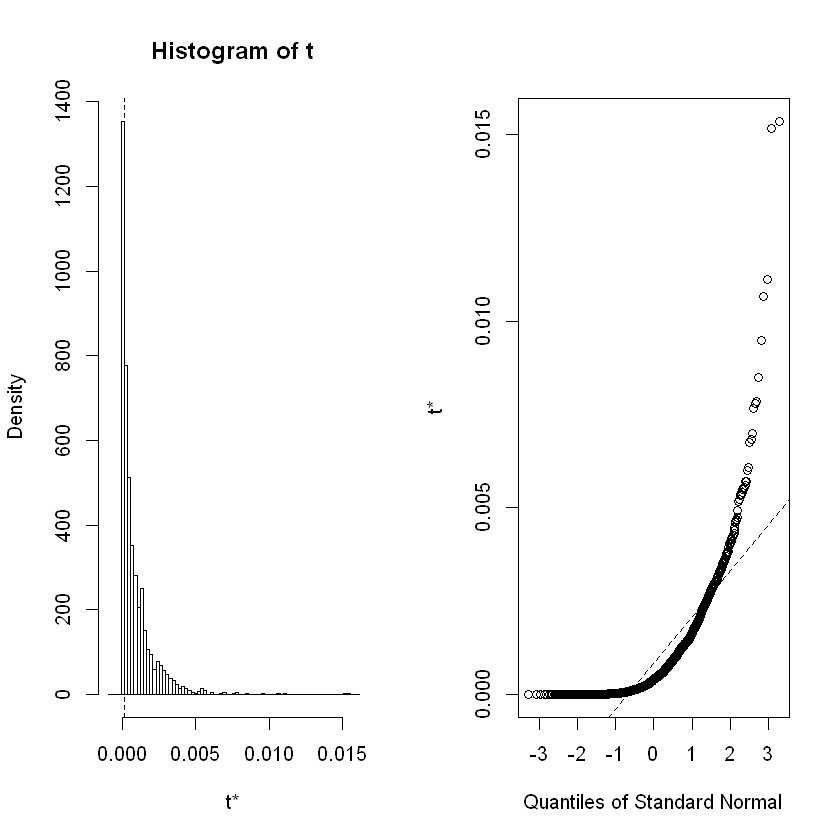

In [147]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~NumberOfStudents)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    SalaryTotals)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.1333501 0.0002369435  0.01486246

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1056,  0.1634 )  
Calculations and Intervals on Original Scale

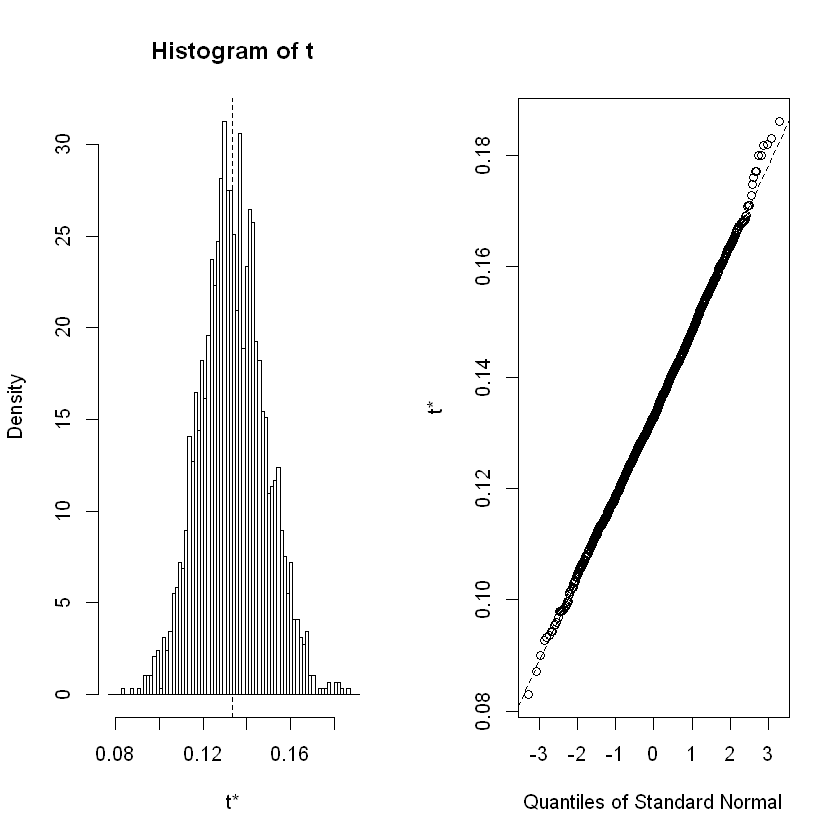

In [148]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~SalaryTotals)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    AverageSalary)


Bootstrap Statistics :
      original       bias    std. error
t1* 0.02579256 0.0008435892 0.009192464

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0109,  0.0467 )  
Calculations and Intervals on Original Scale

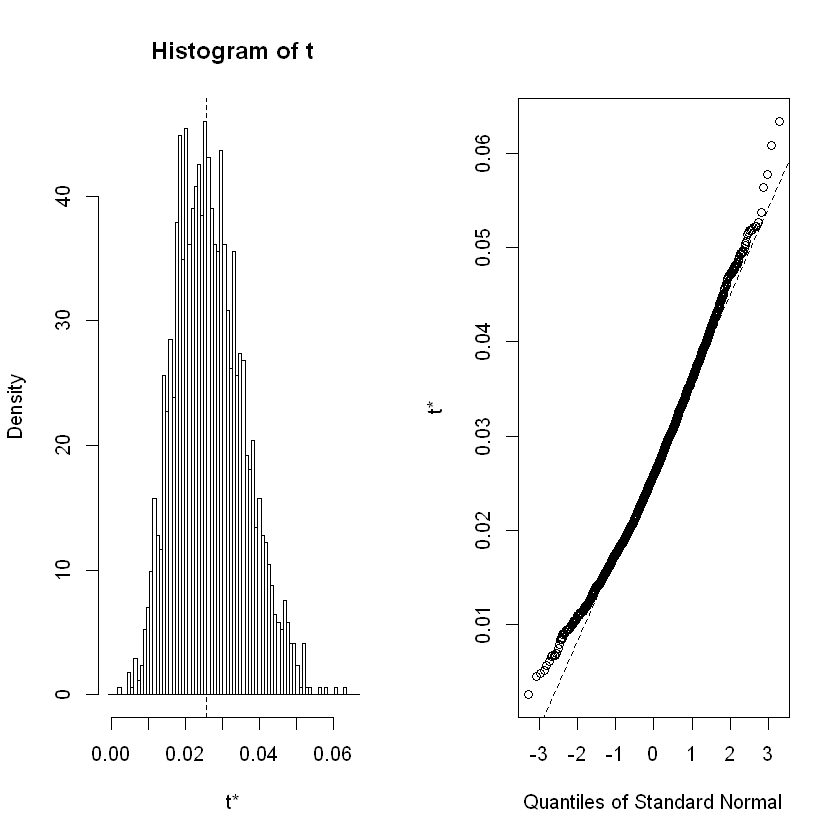

In [149]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~AverageSalary)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    FTECount)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.1544095 0.0005591192  0.01579561

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1231,  0.1841 )  
Calculations and Intervals on Original Scale

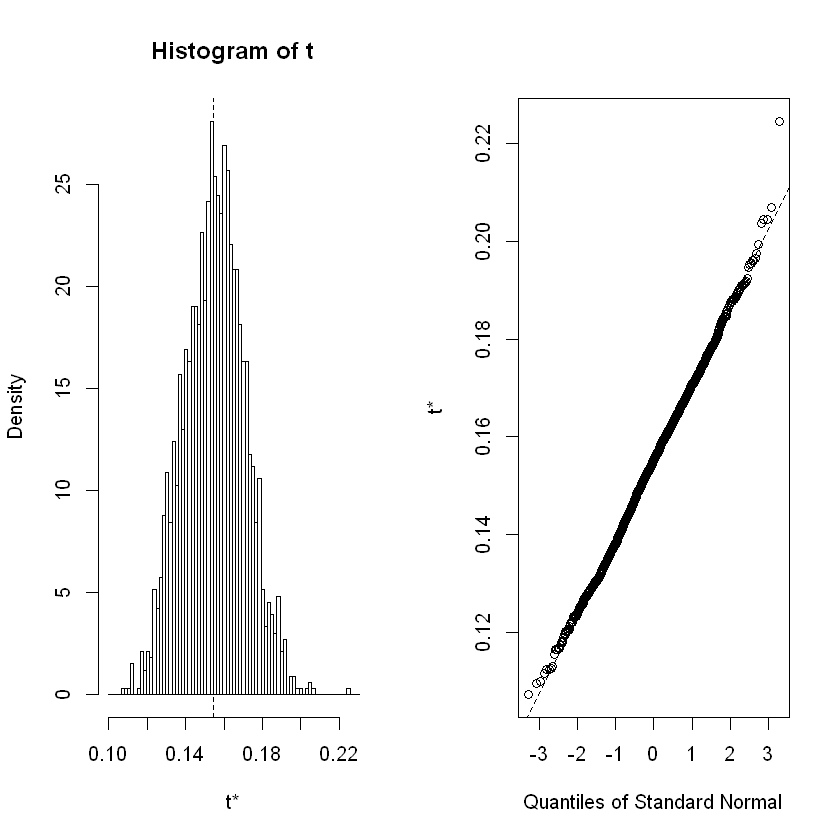

In [150]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~FTECount)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    InDistrictExpenditures)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.1325569 0.000520791  0.01494455

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1019,  0.1612 )  
Calculations and Intervals on Original Scale

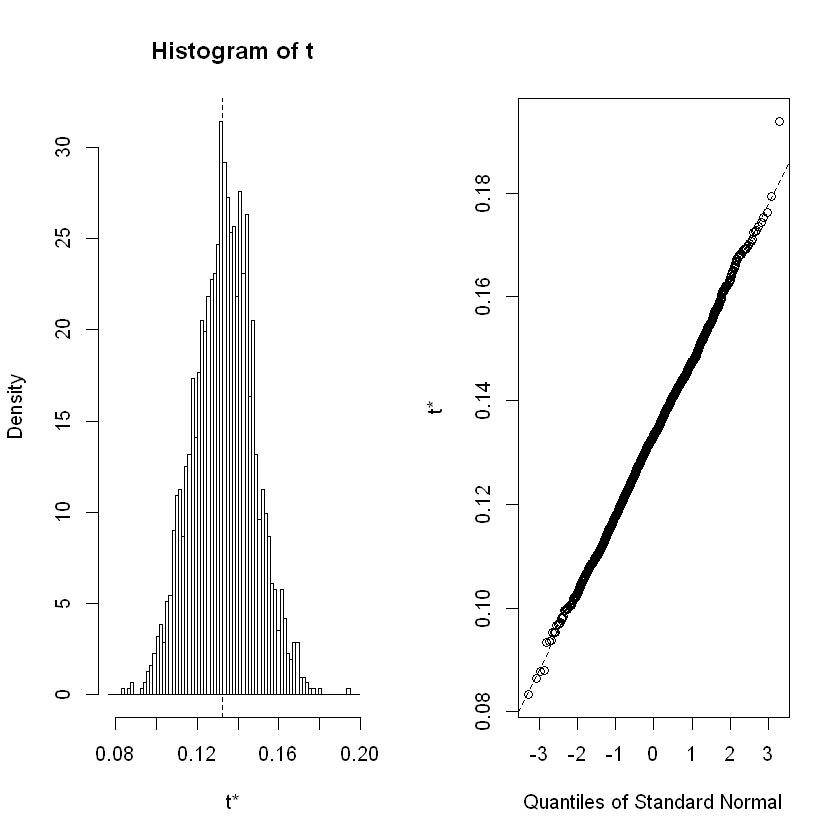

In [151]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~InDistrictExpenditures)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    TotalInDistrictFTEs)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.1557427 0.0004842875  0.01622927

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1211,  0.1864 )  
Calculations and Intervals on Original Scale

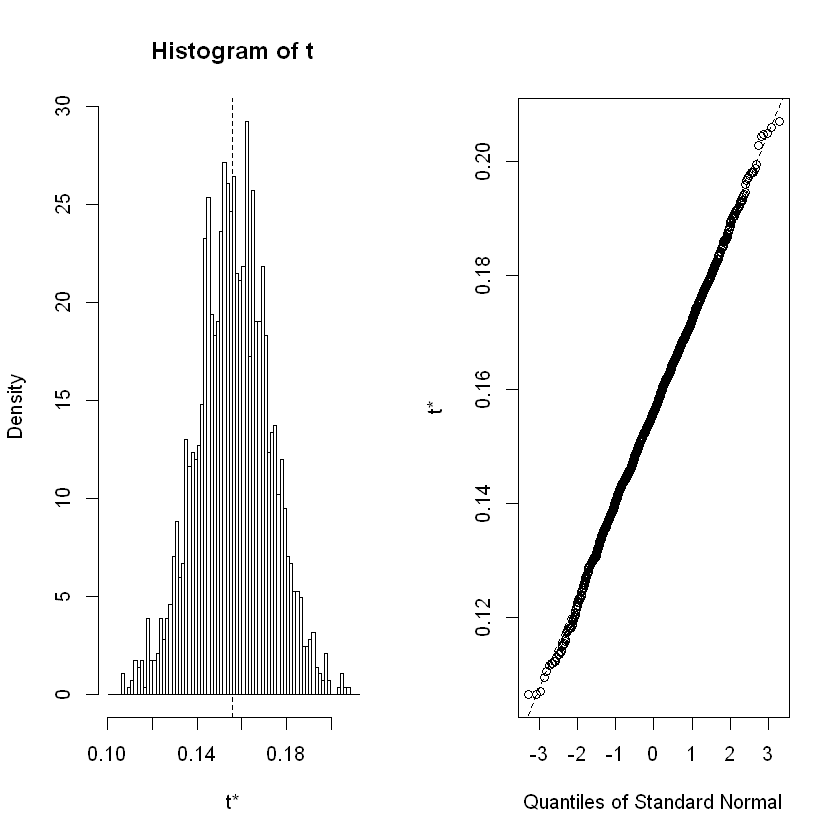

In [152]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~TotalInDistrictFTEs)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    AverageInDistrictExpendituresPerPupil)


Bootstrap Statistics :
      original       bias    std. error
t1* 0.01063101 0.0007734596 0.005035371

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0033,  0.0219 )  
Calculations and Intervals on Original Scale

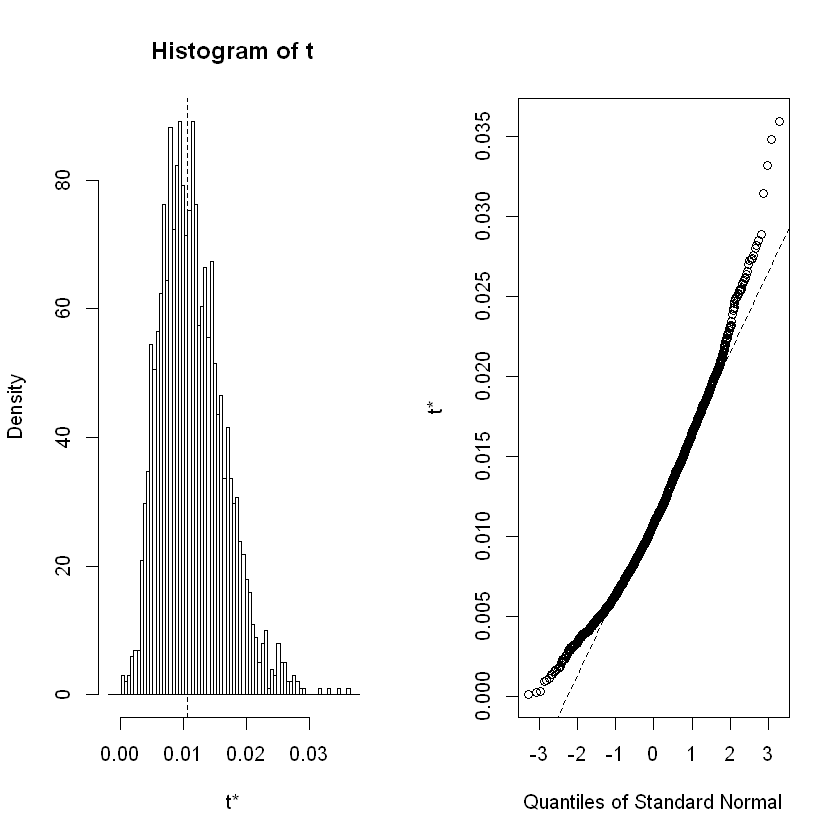

In [153]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~AverageInDistrictExpendituresPerPupil)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    TotalExpenditures)


Bootstrap Statistics :
    original      bias    std. error
t1* 0.132971 0.000266706  0.01467536

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1047,  0.1618 )  
Calculations and Intervals on Original Scale

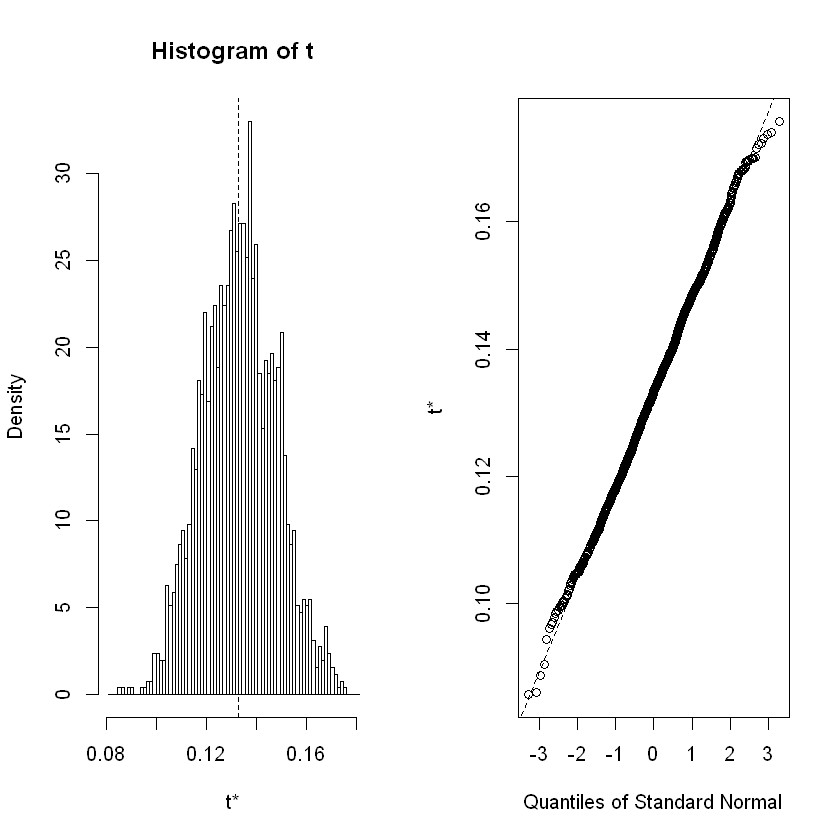

In [154]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~TotalExpenditures)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    TotalPupilFTEs)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.1577857 0.0005586362  0.01602709

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1267,  0.1900 )  
Calculations and Intervals on Original Scale

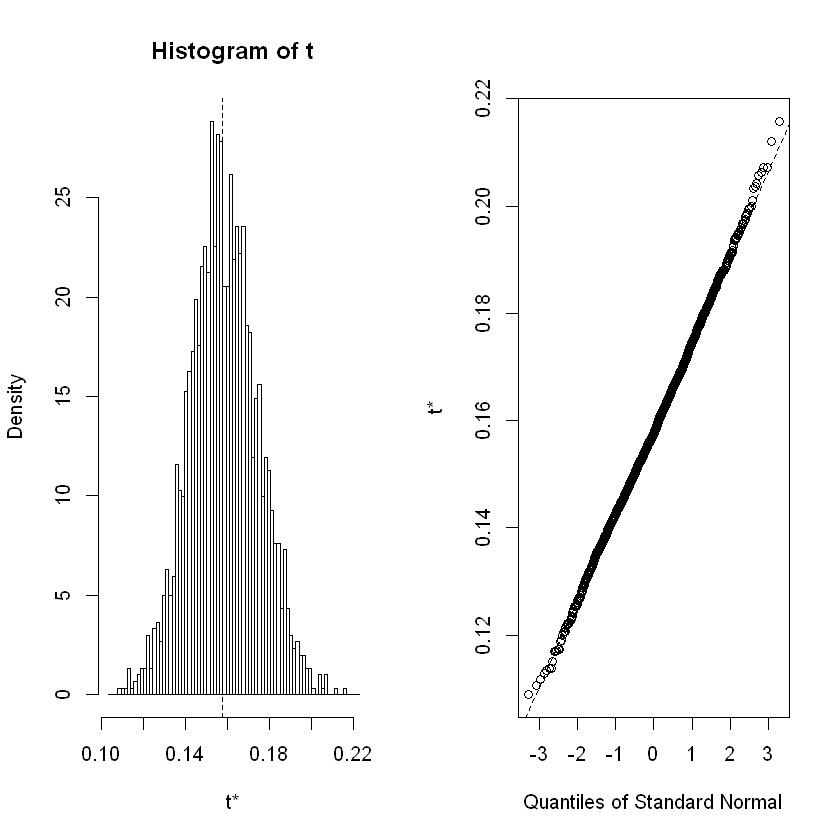

In [155]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~TotalPupilFTEs)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    AverageExpendituresPerPupil)


Bootstrap Statistics :
       original       bias    std. error
t1* 0.001260828 0.0006611398 0.001902127

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.0000,  0.0062 )  
Calculations and Intervals on Original Scale

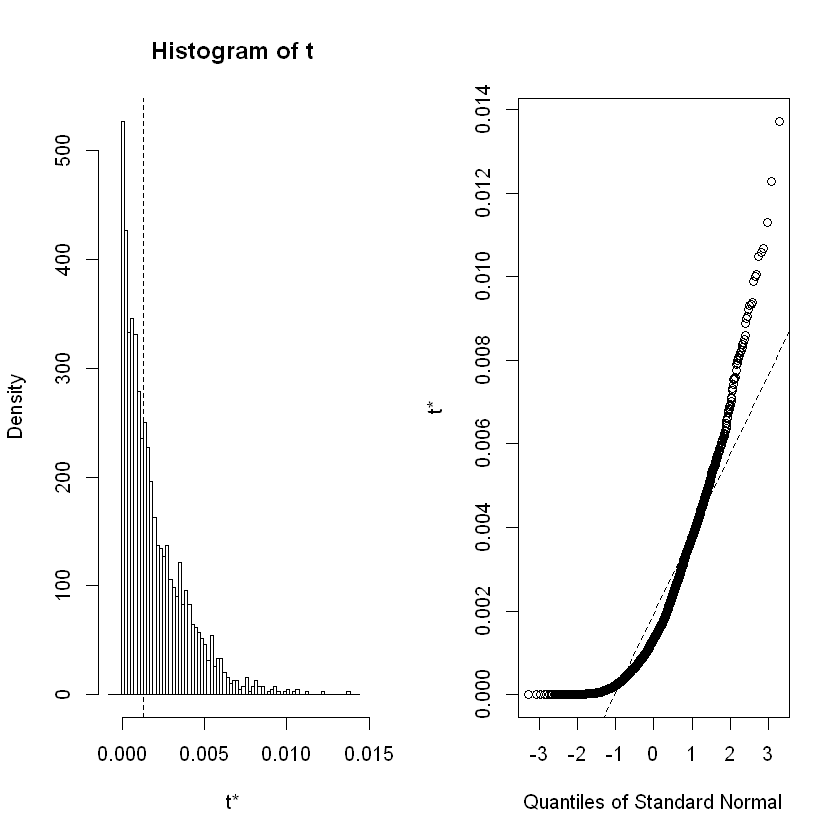

In [156]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~AverageExpendituresPerPupil)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    AccountabilityAndAssistanceLevel)


Bootstrap Statistics :
    original       bias    std. error
t1* 0.466156 0.0005511235  0.01870299

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.4274,  0.5018 )  
Calculations and Intervals on Original Scale

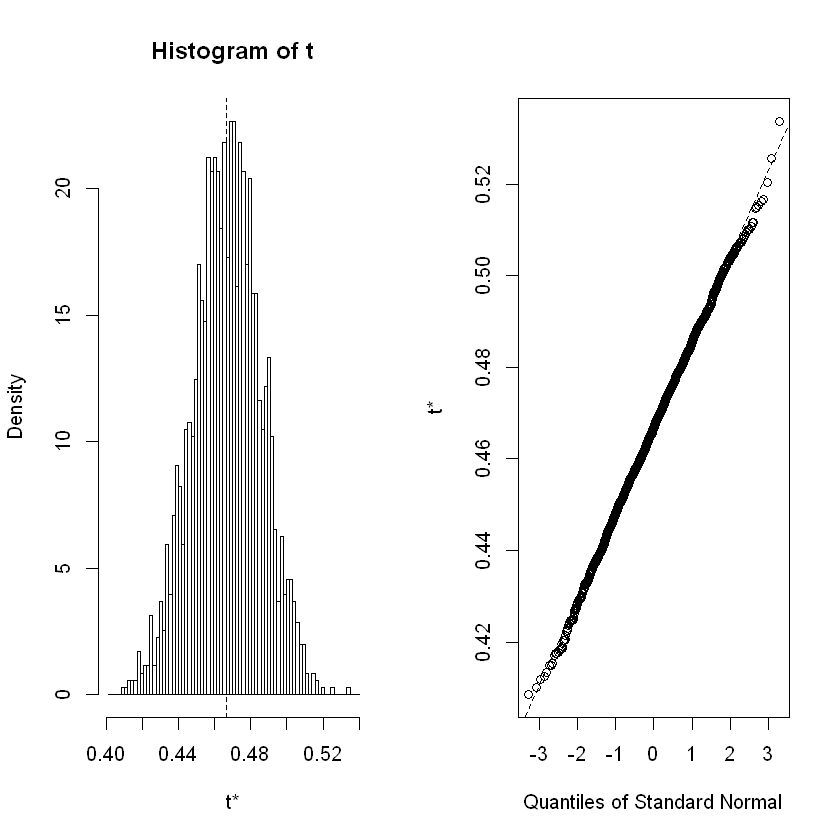

In [157]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~AccountabilityAndAssistanceLevel)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    AccountabilityAndAssistanceDescription)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.4921244 0.002362628  0.01797673

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.4518,  0.5252 )  
Calculations and Intervals on Original Scale

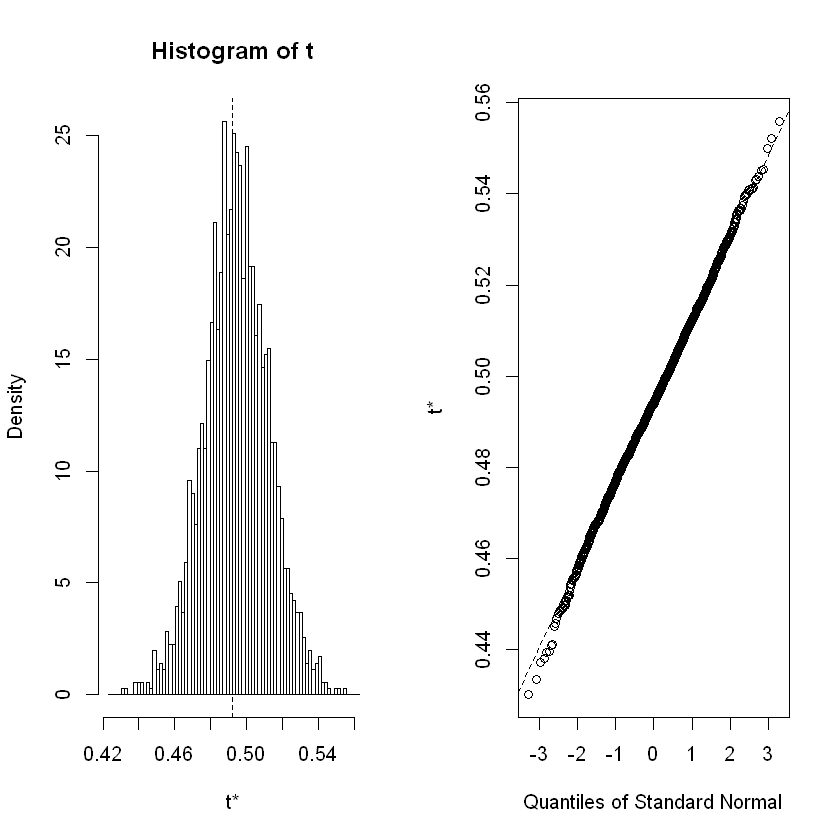

In [160]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~AccountabilityAndAssistanceDescription)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    ProgressAndPerformanceAll)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.4258115 0.000200301  0.01964926

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.387,  0.465 )  
Calculations and Intervals on Original Scale

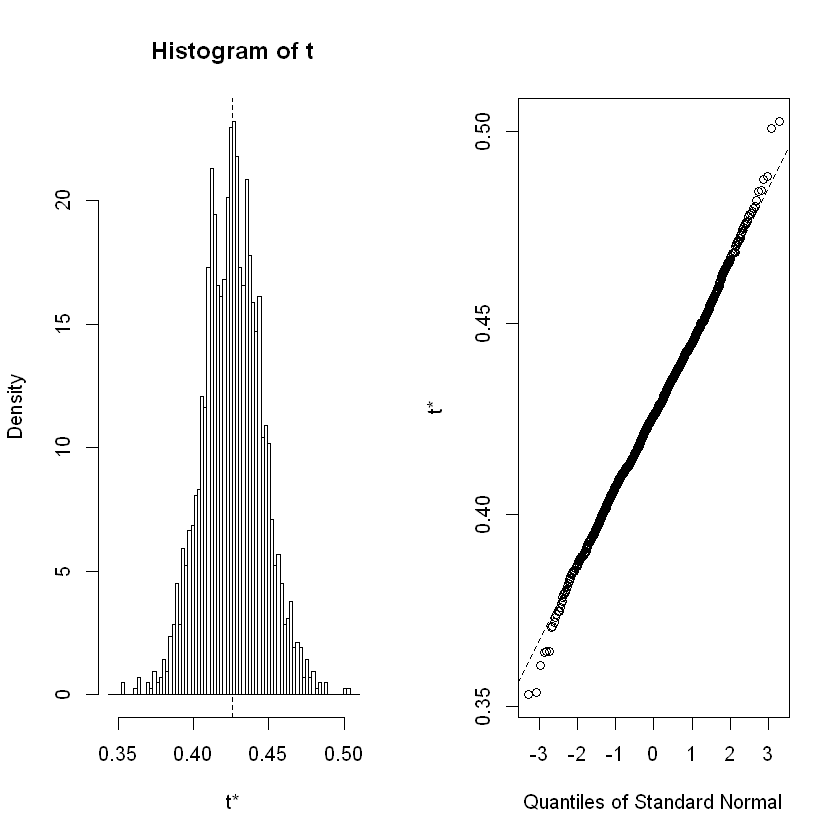

In [161]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~ProgressAndPerformanceAll)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    ProgressAndPerformanceHighNeeds)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.1622253 0.0008784418  0.01719756

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.1293,  0.1952 )  
Calculations and Intervals on Original Scale

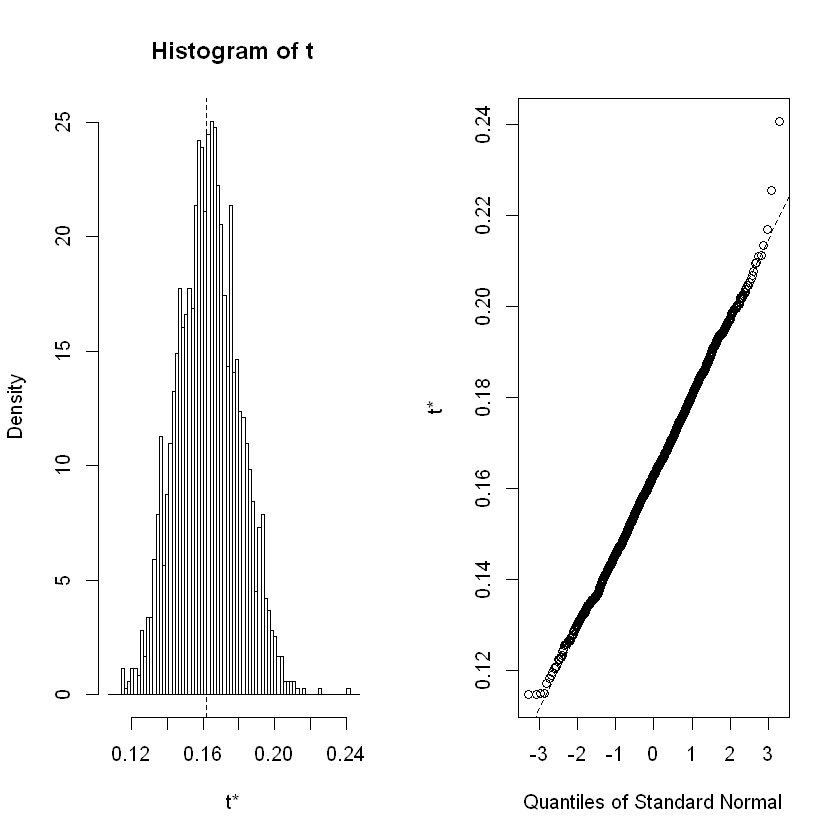

In [162]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~ProgressAndPerformanceHighNeeds)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    DistrictAccountability)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.4495904 0.001294477  0.01988128

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.4084,  0.4875 )  
Calculations and Intervals on Original Scale

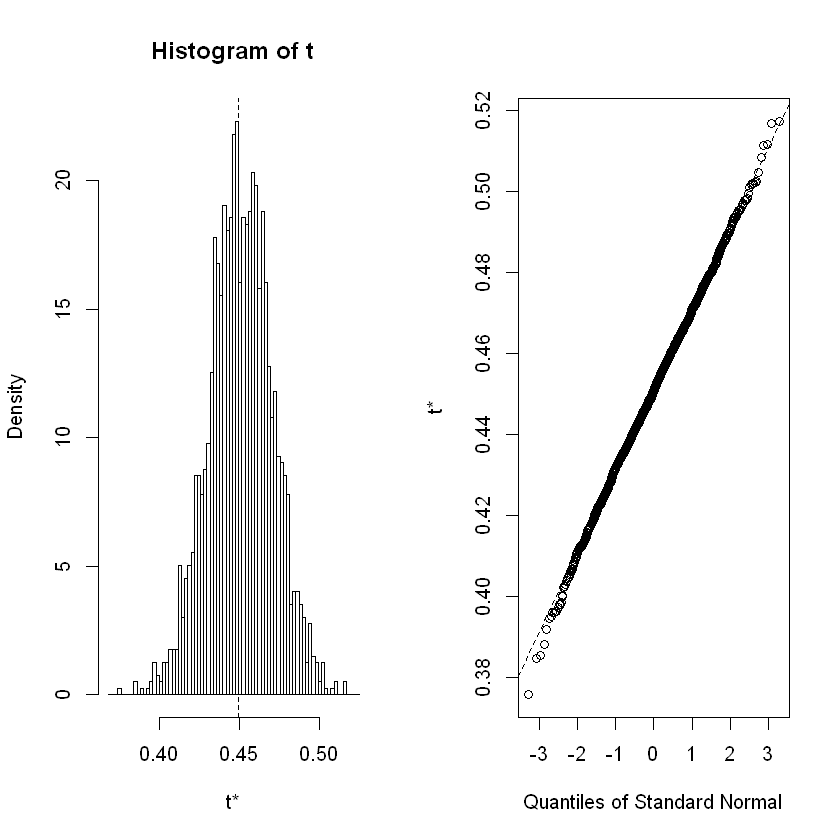

In [163]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~DistrictAccountability)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    DistrictProgressAndPerformanceAll)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.5093137 0.0005056516  0.01644252

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.4749,  0.5395 )  
Calculations and Intervals on Original Scale

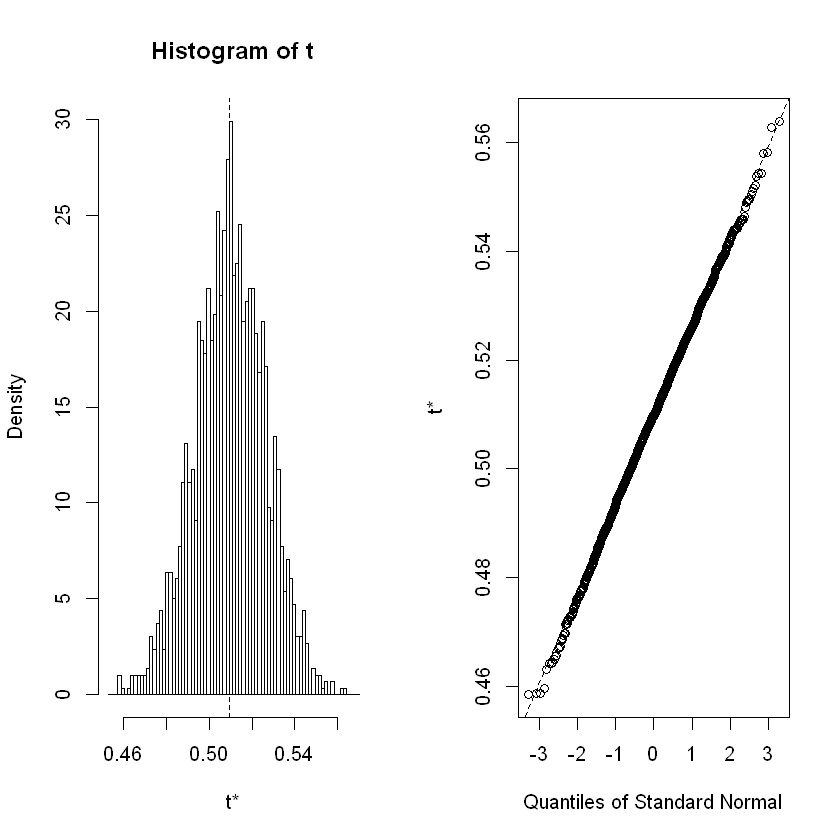

In [164]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~DistrictProgressAndPerformanceAll)
results 
plot(results)
boot.ci(results, type="bca")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = school.perf.scale, statistic = rsq, R = 2000, formula = SchoolAccountablityPercentile ~ 
    DistrictProgressAndPerformanceHighNeeds)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.2521613 0.0003849838  0.01834923

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = results, type = "bca")

Intervals : 
Level       BCa          
95%   ( 0.2158,  0.2874 )  
Calculations and Intervals on Original Scale

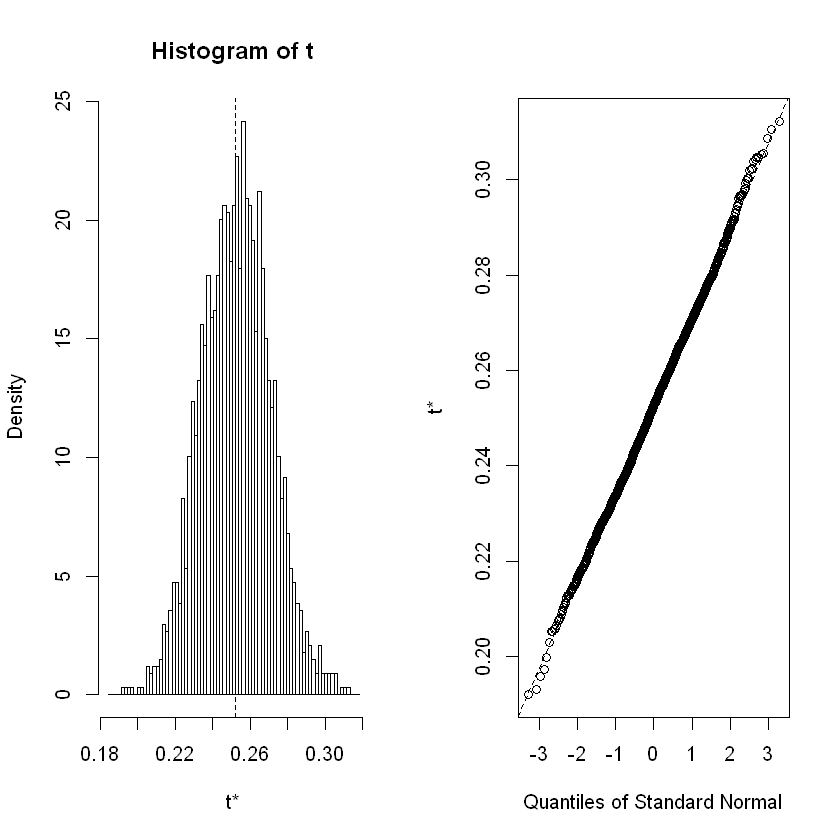

In [165]:
results <- boot(data=school.perf.scale, statistic=rsq, R=2000, formula=SchoolAccountablityPercentile~DistrictProgressAndPerformanceHighNeeds)
results 
plot(results)
boot.ci(results, type="bca")

In [166]:
require(boot)
school.perf.coeff.clean <- school.perf.coeff
names(school.perf.coeff.clean)
# sapLm <- lm(SchoolAccountablityPercentile ~ TotalEnrollment+FirstLanguageNotEnglish+PctFirstLanguageNotEnglish+
#             EnglishLanguageLearner+PctEnglishLanguageLearner+StudentsWithDisabilities+PctStudentsWithDisabilities+HighNeeds+
#             PctHighNeeds+EconomicallyDisadvantaged+PctEconomicallyDisadvantaged+TotalNoOfClasses+AverageClassSize+
#             NumberOfStudents+SalaryTotals+AverageSalary+FTECount+InDistrictExpenditures+TotalInDistrictFTEs+
#             AverageInDistrictExpendituresPerPupil+TotalExpenditures+TotalPupilFTEs+AverageExpendituresPerPupil+
#             AccountabilityAndAssistanceLevel+ProgressAndPerformanceAll+ProgressAndPerformanceHighNeeds+
#             DistrictAccountability+DistrictProgressAndPerformanceAll+DistrictProgressAndPerformanceHighNeeds+SchoolType
#             -1
#                  , data = school.perf.coeff.clean)


sapLm <- lm(SchoolAccountablityPercentile ~ PctEconomicallyDisadvantaged +
            DistrictProgressAndPerformanceAll + ProgressAndPerformanceAll + EconomicallyDisadvantaged
            -1 ,data = school.perf.scale)
lm.boot(sapLm, 10000)
summary(sapLm)

[1] "SchoolCode"                             
 [2] "SchoolName"                             
 [3] "SchoolType"                             
 [4] "Grade"                                  
 [5] "TotalEnrollment"                        
 [6] "FirstLanguageNotEnglish"                
 [7] "PctFirstLanguageNotEnglish"             
 [8] "EnglishLanguageLearner"                 
 [9] "PctEnglishLanguageLearner"              
[10] "StudentsWithDisabilities"               
[11] "PctStudentsWithDisabilities"            
[12] "HighNeeds"                              
[13] "PctHighNeeds"                           
[14] "EconomicallyDisadvantaged"              
[15] "PctEconomicallyDisadvantaged"           
[16] "TotalNoOfClasses"                       
[17] "AverageClassSize"                       
[18] "NumberOfStudents"                       
[19] "SalaryTotals"                           
[20] "AverageSalary"                          
[21] "FTECount"                               
[22] "InDistrictExpenditures"                 
[23] "TotalInDistrictFTEs"                    
[24] "AverageInDistrictExpendituresPerPupil"  
[25] "TotalExpenditures"                      
[26] "TotalPupilFTEs"                         
[27] "AverageExpendituresPerPupil"            
[28] "AccountabilityAndAssistanceLevel"       
[29] "AccountabilityAndAssistanceDescription" 
[30] "SchoolAccountablityPercentile"          
[31] "ProgressAndPerformanceAll"              
[32] "ProgressAndPerformanceHighNeeds"        
[33] "DistrictAccountability"                 
[34] "DistrictProgressAndPerformanceAll"      
[35] "DistrictProgressAndPerformanceHighNeeds"

BOOTSTRAP OF LINEAR MODEL  (method = rows)

Original Model Fit
------------------
Call:
lm(formula = SchoolAccountablityPercentile ~ PctEconomicallyDisadvantaged + 
    DistrictProgressAndPerformanceAll + ProgressAndPerformanceAll + 
    EconomicallyDisadvantaged - 1, data = school.perf.scale)

Coefficients:
     PctEconomicallyDisadvantaged  DistrictProgressAndPerformanceAll  
                         -0.51328                            0.17781  
        ProgressAndPerformanceAll          EconomicallyDisadvantaged  
                          0.32401                           -0.08067  



Call:
lm(formula = SchoolAccountablityPercentile ~ PctEconomicallyDisadvantaged + 
    DistrictProgressAndPerformanceAll + ProgressAndPerformanceAll + 
    EconomicallyDisadvantaged - 1, data = school.perf.scale)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.76038 -0.28119 -0.00718  0.29142  1.66508 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
PctEconomicallyDisadvantaged      -0.51328    0.01755 -29.247  < 2e-16 ***
DistrictProgressAndPerformanceAll  0.17781    0.01723  10.318  < 2e-16 ***
ProgressAndPerformanceAll          0.32401    0.01511  21.443  < 2e-16 ***
EconomicallyDisadvantaged         -0.08067    0.01529  -5.277  1.5e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4583 on 1537 degrees of freedom
Multiple R-squared:  0.7904,	Adjusted R-squared:  0.7898 
F-statistic:  1449 on 4 and 1537 DF,  p-value: < 2.2e-16
